In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import os.path
import matplotlib.patches as mpatches
import sqlite3
import datetime
import nltk
nltk.download('stopwords', quiet=True)
import plotly.express as px
from nltk.corpus import stopwords
from IPython.display import Image
from IPython.core.display import HTML
from wordcloud import WordCloud

from sqlalchemy import create_engine
from sqlalchemy.engine.reflection import Inspector

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

plt.rcParams["figure.figsize"] = (12, 8)

from sklearn import decomposition
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.base import clone


In [4]:
def build_df(df, features_to_be_used, decade=None):
    """Return filtered pandas DataFrame, `players` names and `feature_names`

    Parameters
    ----------
    df : pandas DataFrame
        original df data for filtering
    features_to_be_used : list
        list to retain as features
    decade : int, optional
        `Year` filter

    Returns:
    ----------
    df : pandas DataFrame
        Filtered df based on inputs `year`, `min_mins_played` and `pos`
    song_titles : list
        list of songs
    feature_names : list
        list of feature names
    """

    if decade is not None:
        df = df[df['decade'] == decade]
    songs = list(df.loc[:, 'title'])
    artists = list(df.loc[:, 'artist'])
    df = df.loc[:, features_to_be_used]
    feature_names = list(df.columns)
    return df, songs, artists, feature_names

def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    
    ssd = 0
    for cluster_group in set(y):
        for j in range(X.shape[0]):
            in_cluster_dist = dist(X[j], centroids[cluster_group])
            count_cluster_size = y.tolist().count(cluster_group)
            ssd += np.where(y[j] == cluster_group,
                            in_cluster_dist**2/(2*count_cluster_size),
                            0)
    return ssd

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """

    rng = np.random.default_rng(random_state)
    W_k = pooled_within_ssd(X, y, centroids, dist)
    gap_s = []
    W_ki_s = []
    clusterer = clone(clusterer)
    for iteration in range(b):
        x1 = rng.uniform(low=X.min(axis=0), high=X.max(axis=0), size=X.shape)
        y1 = clusterer.fit_predict(x1)
        W_ki = pooled_within_ssd(x1, y1, clusterer.cluster_centers_, dist)
        gap_s.append(np.log(W_ki) - np.log(W_k))
    gs = np.mean(gap_s)
    gss = np.std(gap_s) 
    return gs, gss

def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    """
    Return a dictionary of cluster labels, internal validation values, and
    if actual labels is given, external validation values, for every k.
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    k_start : int
        Initial value of cluster steps
    k_stop : int
        Final value of cluster steps
    actual : array, optional
        List of ground-truth labels

    Returns
    -------
    cluster_range : dictionary
        dictionary of cluster labels, internal validation values, and
        external validation values, for every k
    """

    X = X.to_numpy()
    ys = []
    centers = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        clusterer_k.set_params(n_clusters=k)
        y = clusterer_k.fit_predict(X)
        ys.append(y)
        centers.append(clusterer_k.cluster_centers_)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_, 
                                 euclidean, 5, 
                                 clone(clusterer).set_params(n_clusters=k), 
                                 random_state=1337)
        gss.append(gs[0])
        gssds.append(gs[1])
        if actual is not None:
            ps.append(purity(actual, y))
            amis.append(adjusted_mutual_info_score(actual, y))
            ars.append(adjusted_rand_score(actual, y))
    cluster_range = {'ys':ys, 'centers': centers, 'inertias':inertias, 
                     'chs':chs, 'scs':scs, 'gss':gss, 'gssds':gssds}
    if actual is not None:
        cluster_range['ps'] = ps
        cluster_range['amis'] = amis
        cluster_range['ars'] = ars
    return cluster_range

def k_means_test(df, features, clusterer=None, decade=None, k=2, pc=7,
                 plot=False, k_start=1, k_end=1, actual=None):
    """
    Return cluster labels and standardized design matrix.
    
    Parameters
    ----------
    df : pandas DataFrame
        df for processing
    features : list
        list of features
    decade : int, optional
        `Year` filter
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    k : int, optional
        number of clusters to be formed
    pc : int, optional
        number of principal components to be used
    plot : boolean, optional
        Indicator whether an axes plot is to be shown or not    
    k_stop : int
        Final value of cluster steps
    actual : array, optional
        List of ground-truth labels

    Returns
    -------
    y_predict : array
        array of predicted clusters according to `clusterer`
    X_std : numpy design matrix
        numpy matrix of standardized features
    """

    # filter df for analysis
    df_filtered, songs, artists, feature_names = build_df(df,
                                                          features,
                                                          decade=decade)

    # Standardize input pandas DataFrame
    X = df_filtered.to_numpy()
    X_std = (X - X.mean(axis=0))/X.std(axis=0)
    pca = decomposition.PCA()
    X_std_PCA = pca.fit_transform(X_std)
    p = pca.components_.T

    kmeans_df = KMeans(n_clusters=k, random_state=1337)
    y_predict = kmeans_df.fit_predict(X_std_PCA[: , :pc])
    y_centers = kmeans_df.cluster_centers_

    spotify_color = (sns.color_palette('Greens')[1::2][::-1] 
                     + sns.color_palette('binary')[0:4])

    X_std_PCA_df = pd.DataFrame(X_std_PCA)
    X_std_PCA_df['y_predict'] = y_predict

    if plot == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
        k_clusters = str(k) + ' clusters'
        
        sns.scatterplot(data=X_std_PCA_df, x=0, y=1, hue='y_predict',
                        palette=spotify_color[:k], ax=ax1)
        sns.scatterplot(data=pd.DataFrame(y_centers), x=0, y=1, color='red',
                        ax=ax1)
        
        for cluster, vec in zip(range(k), y_centers):
            cluster_label = 'Cluster ' + str(cluster) + ' centroid'
            ax1.text(vec[0], vec[1]+0.1, cluster_label, ha='center',
                     color='black', fontsize=10)
        
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_title('Scatter Plot with Clustering')
        
        res_decade = cluster_range(df_filtered, clusterer, k_start, k_end,
                                   actual)
        ks = np.arange(2, len(res_decade['inertias'])+2)
        ax2.plot(ks, res_decade['inertias'], '-o', color=spotify_color[1], 
                 label='SSE')
        ax2.plot(ks, res_decade['chs'], '-o', color=spotify_color[3], 
                 label='CH')
        ax2.set_xlabel('$k$')
        ax2.set_ylabel('SSE/CH')
        lines, labels = ax2.get_legend_handles_labels()
        ax2a = ax2.twinx()
        ax2a.errorbar(ks, res_decade['gss'], res_decade['gssds'], fmt='-o', 
                      color=spotify_color[6], label='Gap statistic')
        ax2a.plot(ks, res_decade['scs'], '-o', color=spotify_color[0], 
                  label='Silhouette coefficient')
        ax2a.set_ylabel('Gap statistic/Silhouette')
        lines2, labels2 = ax2a.get_legend_handles_labels()
        ax2a.legend(lines+lines2, labels+labels2)
        ax2.set_title('Internal Validation')
        
        plt.tight_layout()
        plt.show()
    
    return y_predict, X_std

def boxplot(df, decade):
    """Return boxplots of features in the `df` per `decade`."""

    df = pd.DataFrame(df, columns=features)
    df['cluster'] = y_predict
    
    spotify_color = (sns.color_palette('Greens')[1::2][::-1] 
                     + sns.color_palette('binary')[0:4])
    order = decade
    fig, ax = plt.subplots(3, 3, figsize=(6, 6), dpi=100)
    features_for_plot = [['loudness', 'danceability', 'energy'],
                         ['acousticness', 'valence', 'tempo'],
                         ['instrumentalness', 'speechiness', 'liveness']]
    for i in range(3):
        for j in range(3):
            sns.boxplot(data=df, x='cluster', y=features_for_plot[i][j],
                        palette=spotify_color, linewidth=1, ax=ax[i][j])
            ax[i][j].set(title=features_for_plot[i][j], xlabel='cluster', 
                         ylabel='')
    plt.tight_layout()
    plt.show()
    
def wordcloud_clstr(df, cluster, show='song'):
    """Return wordcloud plots under column `show` from column `cluster`
    in `df`.
    """

    from wordcloud import WordCloud, STOPWORDS

    comment_words = ''
    add_words = ['remastered', 'remaster', 'version', 'single',
                'mono', 'stereo', 'feat']
    stopwords = set(list(STOPWORDS) + add_words)

    for val in df_all.loc[df_all['cluster_label'] == cluster][show]:

        # typecast each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    return WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = stopwords,
                          min_font_size = 20).generate(comment_words)

In [5]:
spotify_color = (sns.color_palette('Greens')[1::2][::-1] 
                 + sns.color_palette('binary')[0:4])

features = ['danceability', 'energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo']

len_features = len(features)

decade_list = [50, 60, 70, 80, 90, 0, 10]
clusters_per_decade = [3, 2, 2, 2, 3, 3, 4]
pcs_per_decade = [7, 7, 7, 7, 7, 7, 7]

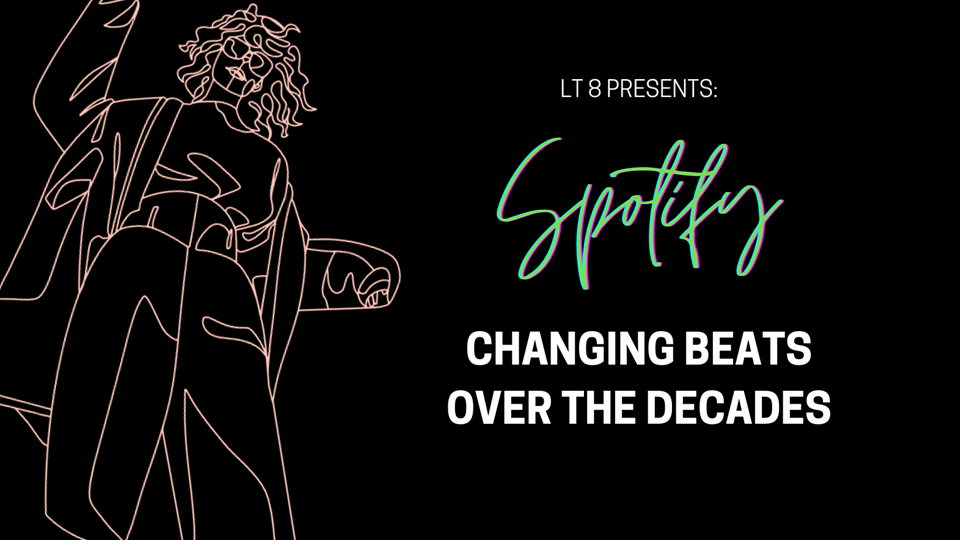

In [6]:
Image(filename="header.png")

# Spotify: Changing Beats Over the Decades

## Executive Summary

<div style='text-align: justify;'> <i><b>"A good song never gets old."</b></i> This statement encapsulates music across different eras that have captured the hearts of millions of listeners worldwide. Song hits are evident from radio to television and even the digital streaming era, which made us ask <i>"What are the themes present in hit songs?”</i> Our focus is on songs in Spotify, the world’s largest music streaming provider.  Spotify curates themed playlists to engage their wide variety of listeners. In this study, hit songs from <b>Spotify All Out Playlists</b> were analyzed. Each collection contains one hundred and fifty hit songs per decade starting from the 1950's all the way to the 2010's.  The methodology starts with collection of data using Spotify API where data cleaning was also performed. All audio features were gathered and standardized. The dimensions were reduced by using Principal Component Analysis. The team was then able to identify different clusters within each decade and similar clusters between the decades through KMeans Clustering. </div><br>

<div style='text-align: justify;'>This paper is beneficial for three sectors: <b>Artists, Spotify users, and Spotify, Inc</b>. Our findings can help these sectors understand global musical preference. Artists, musician, and producers are able to ride the waves of popular emotial but upbeat songs, create happy songs, or revive and be inspired by themes of the past such as sentimental dance songs. Using our identified clusters, subscribers are able to discover songs from other decades that are similar to their preferred cluster. Spotify is also able to harness our analysis in clustering to diversify song choices and improve their playlists and catalogue of songs. </div><br>

<div style='text-align: justify;'> Five unique musical themes emerged from our group's analysis: <b>"Easy Pop/Rock", "Senti", "Move", "Chill", and "Alt"</b> . “Easy Pop/Rock” contains songs that are happy, upbeat, and can boost your mood;  “Senti” has songs that are generally unhappy and relatable;  “Move” hits are great for dancing or parties; “Chill”  has songs with relaxing beats, perfect for chill and slow dancing; and “Alt” which has tunes that emotional but upbeat. Among these clusters, “Move” and “Senti” are present most of the decades. “Easy Pop/Rock” songs were most popular before 2000’s while “Alt” emerged at the start of 2000’s. It is noteworthy  that the “Chill” cluster emerged when the “Senti” cluster faded and happier songs are present in the majority of each decade. Finally, the “Alt” cluster appeared at the start of 2000’s which ushered in a new wave of song preference that encourages rising above adversity.</div><br>

<div style='text-align: justify;'> For future studies, we recommend that researchers explore more playlists, songs, and features. They can take it a step further by analyzing actual song lyrics instead of just song titles to get a deeper look into themes through clustering. They can also try utilizing more clustering techniques, validation methods, and possibly soft clusters across decades. Next steps include reverse engineering on Spotify song audio features and performing machine learning algorithms. </div>

## Table of Contents

* Executive Summary
* Introduction
* Problem Statement and Motivation
* Data Description 
* Methodology
   - Data Extraction and Collection
   - Dimensionality Reduction
   - Clustering 
   - Data Analysis
* Results
   - Exploratory Data Analysis
   - Principal Component Analysis
   - Clustering
   - Cluster Description, Labeling, and Interpretation
   - Evolution Through the Decades
       - Presence per Decade
       - Distribution per Decade 
* Conclusion and Recommendation
* References
* Appendix

## 1. Introduction

### Spotify
<br>
<div style='text-align: justify;'> Spotify is a Swedish audio streaming and media services provider founded on April 23, 2006 by Daniel Ek and Martin Lorentzon. It is the world's largest music-streaming service provider with over 365 million monthly active users, including 165 million paying subscribers, as of June 2021. Spotify offers digital copyright-restricted recorded music and podcasts, including more than 70 million songs from record labels and media companies.  </div> <br>

<div style='text-align: justify;'>Spotify is available in most of Europe and the Americas, Oceania and more than 40 countries in Africa and Asia as of July 2021. By the end of 2021, Spotify is expected to operate in a total of 178 countries. The service is available on most modern devices including Windows, macOS, and Linux computers, iOS and Android smartphones and tablets and AI enabled smart speakers such as Amazon Echo and Google Home. Unlike physical or download sales, which pay artists a fixed price per song or album sold, Spotify pays royalties based on the number of artist streams as a proportion of total songs streamed. It distributes approximately 70% of its total revenue to rights holders (often record labels), who then pay artists based on contract agreements. </div><br>

<div style='text-align: justify;'>As a "freemium" service, basic features are free with advertisements and limited control, while additional features, such as offline listening and commercial-free listening, are offered via paid subscriptions. Users can search for music based on artist, album, or genre, and can create, edit, and share playlists. An example are the All Out Playlists. Each collection contains one hundred and fifty hit songs per decade starting from the 1950's all the way to the 2010's.</div>

## 2. Problem Statement and Motivation

<br>

<div style='text-align: justify;'>Our group aims to provide an analysis of hits songs from several decades  as featured on Spotify's All Out Playlists based on several prominent audio features. From Spotify data, we aim to provide data-driven answers to the questions: <b><i> “What are the themes present in hit songs?”</i></b>, <b><i>“Are they danceable and loud; sentimental and mellow?”</i></b> and <b><i>“How did these themes change over the decades?”</i></b></div><br>

<div style='text-align: justify;'>We also aim to give an in-depth view of these underlying themes behind the popular songs per decade. The team will cluster these songs and identify trends that could span several generations. Our findings can help musicians, artists, producers, and casual listeners understand global and generational preference to music. By knowing which songs are similar, we can also expand our musical exposure and enjoyment. Finally, Spotify can benefit greatly from the insights on this study to enhance their playlist and song choices.</div>

## 3. Data Description
<br>

<div style='text-align: justify;'>The final database has 1050 rows and 17 columns where each row is a track from the 150 hit songs per decade in <b>Spotify's All Out</b> series. </div><br>
    
<div style='text-align: justify;'>Below are the column descriptions:</div>

<center style="font-size:14px;font-style:default;"><b>Table 3.1 Column Names, Data Type and Description of dmw_spotify.csv</b></center>

| Feature | Type | Description |
| :- | :- | :- |
| id | str | Unique identifier for Spotify tracks |
| artist | str | Artist per track |
| title | str | Title per track |
| release_date | dt | Date when the track was released |
| popularity | int | Spotify's internal popularity ranking system from 0 to 100 |
| decade | int | Decade when the track was released |
| danceability | float | Dance suitability of track |
| energy | float | Perceptual measure of intensity and activity |
| key | int | Pitch or scale of the track |
| loudness | float | Loudness of track in decibels |
| mode | int | Modality (major or minor) of a track |
| speechiness | float | Presence of spoken words in a track |
| acousticness | float | Confidence measure from 0.0 to 1.0 of whether the track is acoustic |
| instrumentalness | float | Prediction of whether a track contains vocals |
| liveness | float | Prediction of audience presence in a track |
| valence | float | Musical positiveness of a track |
| tempo | float | Estimated tempo in beats per minute |

<div style='text-align: justify;'>A table sample can be seen below:</div>

In [48]:
# Sample dataframe
df_csv = pd.read_csv('dmw_spotify.csv')

display(HTML('<center style="font-size:14px;font-style:default;">'
     '<b>Table 3.2 Sample Dataframe</b></center>'))

display(df_csv.head())

id           artist  \
0  01u6AEzGbGbQyYVdxajxqk    Elvis Presley   
1  3aEJMh1cXKEjgh52claxQp    Frank Sinatra   
2  307XEC1IUwUs9ojlEFwH7f     The Platters   
3  5yQ9iMZXGcr5rlO4hoLsP4      Ray Charles   
4  3vFVS2WYHDG4KkWCNecvpn  Ella Fitzgerald   

                                          title release_date  popularity  \
0                                Don't Be Cruel   1958-03-21          60   
1  I've Got You Under My Skin - Remastered 1998      1956-03          67   
2                       Smoke Gets In Your Eyes   1995-01-01           0   
3                       What'd I Say, Pt. 1 & 2         1959          63   
4                    Dream A Little Dream Of Me   1996-06-04           0   

   decade  danceability  energy  key  loudness  mode  speechiness  \
0      50         0.697   0.550    2   -11.496     1       0.1790   
1      50         0.585   0.247    1   -12.612     1       0.0400   
2      50         0.290   0.227    3   -13.060     1       0.0311   
3      50         0.540   0.681    4    -5.440     1       0.0508   
4      50         0.455   0.167    0   -13.613     1       0.0739   

   acousticness  instrumentalness  liveness  valence    tempo  
0         0.856          0.000034    0.0907    0.844   84.802  
1         0.452          0.000009    0.1070    0.591  127.150  
2         0.944          0.000079    0.6170    0.224  114.278  
3         0.808          0.000000    0.1620    0.794   88.385  
4         0.918          0.000000    0.1730    0.404   76.118

In [8]:
# Display Table
display(HTML('<center style="font-size:14px;font-style:default;">'
     '<b>Table 3.3 Feature Description</b></center>'))

display(df_csv.describe())

popularity       decade  danceability       energy          key  \
count  1050.000000  1050.000000   1050.000000  1050.000000  1050.000000   
mean     53.893333    51.428571      0.612347     0.621565     4.929524   
std      26.692188    31.830958      0.144554     0.201734     3.549565   
min       0.000000     0.000000      0.138000     0.021000     0.000000   
25%      51.000000    10.000000      0.526000     0.488500     2.000000   
50%      64.000000    60.000000      0.624000     0.642000     5.000000   
75%      72.000000    80.000000      0.714750     0.782500     8.000000   
max      86.000000    90.000000      0.967000     0.993000    11.000000   

          loudness         mode  speechiness  acousticness  instrumentalness  \
count  1050.000000  1050.000000  1050.000000   1050.000000       1050.000000   
mean     -8.270241     0.753333     0.057788      0.313098          0.015955   
std       3.545951     0.431276     0.055146      0.286685          0.086696   
min     -24.385000     0.000000     0.022800      0.000065          0.000000   
25%     -10.538250     1.000000     0.032200      0.058450          0.000000   
50%      -7.537500     1.000000     0.039250      0.218000          0.000003   
75%      -5.591750     1.000000     0.057175      0.546250          0.000205   
max       1.085000     1.000000     0.466000      0.982000          0.954000   

          liveness      valence        tempo  
count  1050.000000  1050.000000  1050.000000  
mean      0.169972     0.639017   120.131503  
std       0.139132     0.234373    27.363711  
min       0.020700     0.065000    58.686000  
25%       0.086075     0.471000    99.994000  
50%       0.119000     0.671500   118.993500  
75%       0.200750     0.831000   133.027250  
max       0.882000     0.985000   207.356000

<div style='text-align: justify;'>From the quick description above, we can verify that there are no null values in the dataset. Additionally, danceability, energy, mode, acousticness, instrumentalness, and liveness have values from 0.00 to 1.00 only while the rest may have negative values or a value above 1.00.</div>

## 4. Methodology

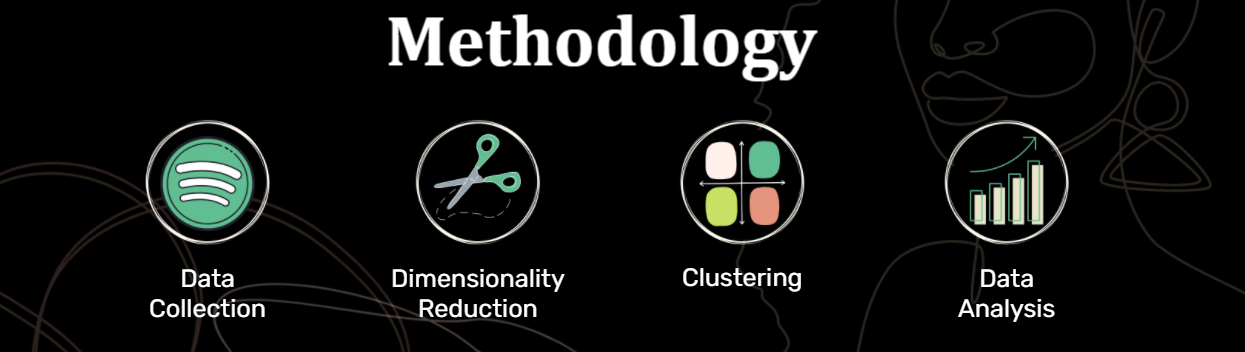

In [9]:
Image(filename="method.PNG")

### 4.1 Data Extraction and Storage
<br>

<div style='text-align: justify;'>Data was collected using Spotify's API. The playlist ID codes were manually collected for each playlist under the All Out Collection by Spotify. These playlist IDs were then used in the first API request. This request collected all of the song details per decade playlist which includes the track ID, track name, artists, release date, decade, and popularity. The end point used was <b>https://api.spotify.com/v1/playlists</b>.</div>
<br>

<div style='text-align: justify;'>The second API request was used the track IDs in order to collect the corresponding audio features per song. The endpoint used was <b>https://api.spotify.com/v1/audio-features</b>. See Table 3.1 for the detailed description of each audio feature. The collected data was then save on a CSV file named <b>dmw_spotify.csv</b>. You can refer to the attached Jupyter notebook <i><b>03_Supplement1_API</b></i> for the code used to extract the playlists and respective audio features.</div>

### 4.2 Dimensionality Reduction
<br>

<div style='text-align: justify;'>Principal component analysis was implemented to analyze the correlation of the features with respect to the new dimensions formed. It was also done to reduce the size of the initial feature set to be used with our chosen clustering methods. Before implementing PCA, several columns were dropped, particularly the non-audio feature columns. PCA was implemented and the number of principal components was determined by setting an <b>explained variance threshold of 80%</b>. Finally, the top two principal components were plotted against each other for dimension identification and feature correlation analysis. </div>

### 4.3 Clustering
<br>

<div style='text-align: justify;'>Clustering was performed using a representative-based clustering method called <b>kMeans clustering</b>. The cluster number was determined using several internal validation methods but the team decided to use Silhouette Coefficient as an estimator of how far apart the clusters are. If the coefficient is closer to 1, it means that the clusters are well separated, so we chose the cluster number with the highest value. The other validation techniques like SSE, Calinski-Harabasz Index and the Gap Statistic were also checked and determined. Each cluster formed was then analyzed using their mean audio features. They were differentiated from each other based on their prominent features. In this report we tried to find the right balance between separation, composition, compactness, and the number of clusters.</div>

### 4.4 Data Analysis
<br>

<div style='text-align: justify;'> The formed clusters were analyzed and counter-checked against its corresponding list of songs. The team also checked the presensce of recurring themes in multiple decades to see the time progression of each cluster.</div>

# 5. Results

### 5.1 Expoloratory Data Analysis

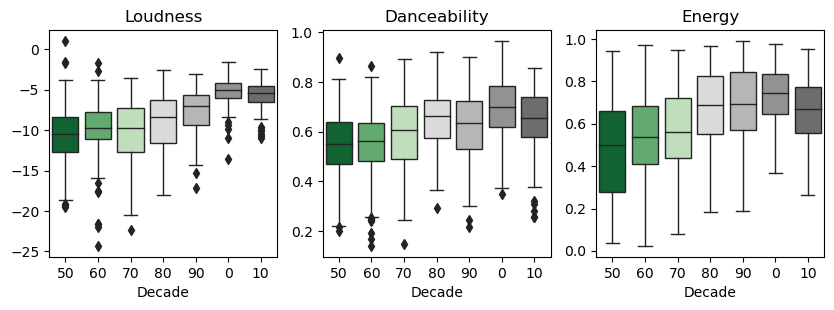

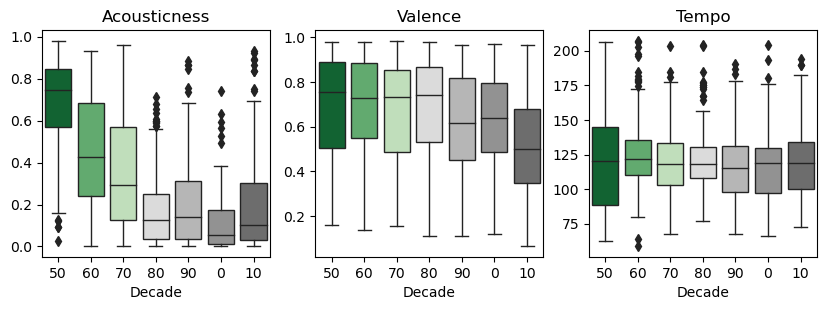

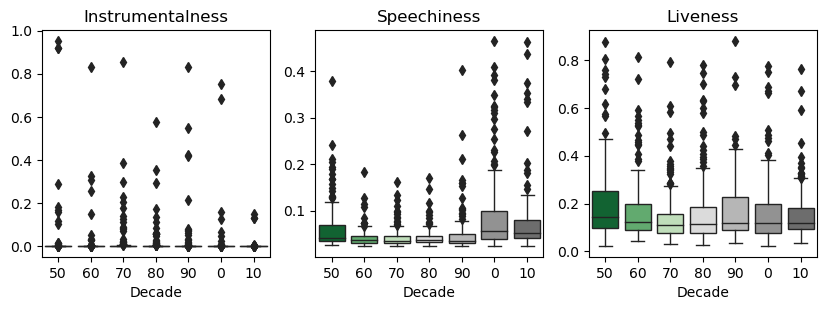

In [10]:
# Plot feature trends per decade
spotify_color = (sns.color_palette('Greens')[1::2][::-1] 
                 + sns.color_palette('binary')[0:4])
sns.color_palette(spotify_color)

def plot_boxplot_eda(df_csv, col1, col2, col3):
    """Plot boxplots of each feature per decade."""
    spotify_color = (sns.color_palette('Greens')[1::2][::-1] 
                     + sns.color_palette('binary')[0:4])
    order = [50, 60, 70, 80, 90, 0, 10]


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), dpi=100)

    sns.boxplot(data=df_csv, x='decade', y=col1, palette=spotify_color,
                linewidth=1, ax=ax1, order=order)
    ax1.set(title=col1.title(), xlabel='Decade', ylabel='')

    sns.boxplot(data=df_csv, x='decade', y=col2, palette=spotify_color,
                linewidth=1, ax=ax2, order=order)
    ax2.set(title=col2.title(), xlabel='Decade', ylabel='')

    sns.boxplot(data=df_csv, x='decade', y=col3, palette=spotify_color,
                linewidth=1, ax=ax3, order=order)
    ax3.set(title=col3.title(), xlabel='Decade', ylabel='')
    plt.show()

plot_boxplot_eda(df_csv, 'loudness', 'danceability', 'energy')
plot_boxplot_eda(df_csv, 'acousticness', 'valence', 'tempo')
plot_boxplot_eda(df_csv, 'instrumentalness', 'speechiness', 'liveness')

<center style="font-size:14px;font-style:default;"><b>Figure 5.1 Audio Feature Comparison Across the Decades</b></center>

<div style='text-align: justify;'>To get an overview of the audio features per decade, we used box plots to visualize the general combination of the features.</div>
<br>

<div style='text-align: justify;'><b>50's.</b> The 50's generally has high acousticness and valence which means that most of the tracks used less intruments that produced sounds through electric or electronic means. Additionally, the tracks mostly conveyed positivity. 50's tracks have low speechiness and liveness. This tells us that the 50's tracks are not heavily loaded with vocals and there was no live audience detected.</div>
<br>

<div style='text-align: justify;'><b>60's.</b> Overall, the 60's tracks have high loudness and valence which means that they are mainly loud songs conveying positive musicality. In terms of acousticness, there was a significant drop from about 0.8 last decade to around 0.4 in the 60's. This shows that the instruments used in this decade produce sound through electric or electronic means. Similarly with the previous decade, 60's tracks have low speechiness and liveness.</div>
<br>

<div style='text-align: justify;'><b>70's.</b> This decade's tracks have slightly higher danceability and energy compared to the last two decades which means they are more suitable for dancing and more intense in nature. A decline in acousticness can also be seen in the plot above.</div>
<br>

<div style='text-align: justify;'><b>80's.</b> In this decade, there was an increase in loudness, danceability, and energy which entails that it is more upbeat and suitable for dancing compared to earlier decades. Acousticness continued to drop in this decade to around 0.2.</div>
<br>

<div style='text-align: justify;'><b>90's.</b> While there is continuous increase in loudness in the 90's, danceability and energy were more or less the same as the previous decade. The 90's also has the lowest tempo compared to all decades which means it is slower or more at ease. Aside from acousticness, valence also dropped in this decade which means that the tracks conveyed less positivity.</div>
<br>

<div style='text-align: justify;'><b>00's.</b> Loudness, danceability, and energy were at their peaks in this decade which means that the tracks are upbeat and danceable. While this decade has the lowest acousticness, it also has the highest speechiness showing that the tracks contain more vocals.</div>
<br>


<div style='text-align: justify;'><b>10's.</b> 10's had the lowest valence among all the decades which tells us that the tracks conveyed the least positivity. Contrary to the preceding decade, loudness, daceability, and energy droppped in this decade. Acousticness, on the other hand, increased slightly after a back-to-back drop in the previous decade. This tells us that the use of intrument-producing sounds through electric or electronic means were less in this decade.</div>

### 5.2 Principal Component Analysis

<div style='text-align: justify;'> Prior to performing clustering, we used dimensionality reduction techniques to minimize the features to be used and maintain sufficient variability of the original dataset <b>(80%)</b>. Our chosen dimensionality reduction techinique is <b>Principal Component Analysis</b> or PCA. PCA is sufficient for this study as the dataset is not sparse. We utilized the first two Principal Components (PCs) to visualize the impact of reduced dimensionality. The scatterplot of the songs among the first two PCs were accompanied by the loadings plot of the features. The loadings plot was helpful in assessing which of the features impacted the respective principal components. Likewise, the arrows where the loadings plot are pointing indicated the behavior of the songs among the songs in the scatter plot.</div> 

In [11]:
def plot_pca_and_var_exp(df, features, decade=None, c1=0, c2=1, t=0.8):
    """Plots loadings graph for PC1 and PC2 and variance explained graph

    Parameters
    ----------
    df : pandas DataFrame
        df for processing
    features : list
        list of features for loadings plot
    decade : int, optional
        `Year` filter
    c1 : int, optional
        index no. 1 of the principal component to be plotted
    c2 : int, optional
        index no. 2 of the principal component to be plotted
    t : float, optional
        threshold to use for the number of principal components to be returned

    Returns
    ----------
    pc_no_threshold: int
        number of PCs to be returned meeting the threshold `t`
    """

    # filter df for analysis
    df_filtered, songs, artists, feature_names = build_df(df,
                                                          features,
                                                          decade=decade)
    # Standardize input pandas DataFrame
    X = df_filtered.to_numpy()
    X_std = (X - X.mean(axis=0))/X.std(axis=0)
    pca = decomposition.PCA()
    X_std_PCA = pca.fit_transform(X_std)

    # Initialize subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

    # First axes: plot the variance explained
    pca_var = pca.explained_variance_ratio_
    sns.lineplot(range(1, len(pca_var) + 1), pca_var*100,
                 label='individual', marker="o", color=spotify_color[6],
                 alpha=0.75, ax=ax1)
    sns.lineplot(range(1, len(pca_var) + 1), pca_var.cumsum()*100,
                 label='cumulative', marker="o", color=spotify_color[0],
                 alpha=0.75, ax=ax1)
    ax1.legend(fontsize=8)
    ax1.set_ylim(0, 105)
    ax1.set_xlabel('PC')
    ax1.set_ylabel('variance explained (%)')
    pc_no_threshold = np.sum(np.where(pca_var.cumsum() < t, 1, 0)) + 1

    # Second axes: scatter plot of observations against PC1 and PC2
    # Identify the max and min values of PC1 and PC2 and corresponding indexes
    max_PC1 = np.amax(X_std_PCA[:, c1])
    max_PC1_idx = np.argmax(X_std_PCA[:, c1])
    max_PC1_PC2 = X_std_PCA[:, c2][max_PC1_idx]
    min_PC1 = np.amin(X_std_PCA[:, c1])
    min_PC1_idx = np.argmin(X_std_PCA[:, c1])
    min_PC1_PC2 = X_std_PCA[:, c2][min_PC1_idx]
    max_PC2 = np.amax(X_std_PCA[:, c2])
    max_PC2_idx = np.argmax(X_std_PCA[:, c2])
    max_PC2_PC1 = X_std_PCA[:, c1][max_PC2_idx]
    min_PC2 = np.amin(X_std_PCA[:, c2])
    min_PC2_idx = np.argmin(X_std_PCA[:, c2])
    min_PC2_PC1 = X_std_PCA[:, c1][min_PC2_idx]
    for_highlight = np.array([max_PC1_idx, max_PC2_idx,
                              min_PC1_idx, min_PC2_idx])

    # Get PCAs
    pcas = np.append(pca.components_.T[:, c1:c1+1],
                     pca.components_.T[:, c2:c2+1], axis=1)
    
    # Compute for weights, rank, then get indices
    weights = np.linalg.norm(pcas, axis=1)
    indexes = weights.argsort()[-20:]

    # Scatter plot for all the players and corresponding PC1 & PC2
    sns.scatterplot(X_std_PCA[:, c1], X_std_PCA[:, c2], alpha=0.75,
                    color=spotify_color[5], ax=ax2)

    # Scatter plot for players with extreme PC1 and PC2 values
    ax2.scatter(X_std_PCA[for_highlight[:, None], c1],
                X_std_PCA[for_highlight, c2],
                alpha=0.8, color='black')
    ax2.text(max_PC1-0.5, max_PC1_PC2, songs[max_PC1_idx],
             ha='center', color='black', fontsize=8)
    ax2.text(max_PC2_PC1, max_PC2-0.5, songs[max_PC2_idx],
             ha='center', color='black', fontsize=8)
    ax2.text(min_PC1+0.5, min_PC1_PC2, songs[min_PC1_idx],
             ha='center', color='black', fontsize=8)
    if decade == 90:
        ax2.text(min_PC2_PC1, min_PC2+0.5, songs[min_PC2_idx][:30],
                 ha='center', color='black', fontsize=8)
    else:
        ax2.text(min_PC2_PC1, min_PC2+0.5, songs[min_PC2_idx],
                 ha='center', color='black', fontsize=8)

    # Loadings plot for the individual statistics
    X_std_PCA_df = pd.DataFrame(X_std_PCA)
    feature_names = np.array(feature_names)
    mult = 1.1*int(np.abs(max_PC1))
    for feature, vec in zip(feature_names[indexes], pcas[indexes]):
        ax2.arrow(0, 0, mult*vec[0], mult*vec[1], width=0.05, head_width=0.1,
                  ec='none', fc=spotify_color[0])
        ax2.text((mult+1)*vec[0], (mult+1)*vec[1], feature, ha='center',
                 color='black', fontsize=6, alpha=1)
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    plt.tight_layout()
    plt.show()
    
    return pc_no_threshold

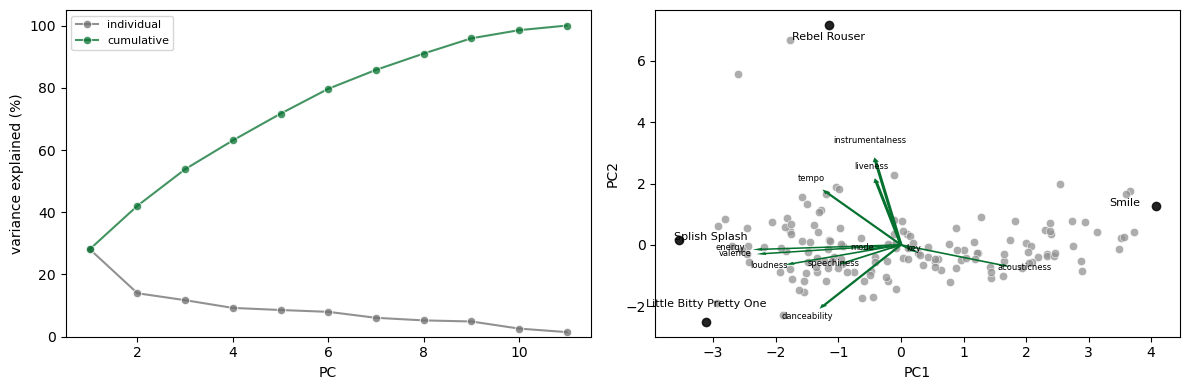

In [12]:
# Plot
pcs1950 = plot_pca_and_var_exp(df_csv, features, decade=50, c1=0, c2=1, t=0.8)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.2 Individual Variance Cumulative Variance of PCs '
             'for 1950 (left) <br>Figure 5.3 Scatter Plot of Songs to PC1 '
             'and PC2 with Loadings Plot for songs in 1950 (right)'
             '</b></center>'))

<div style='text-align: justify;'> For the 1950's decade , we plotted the individual PCs and the cumulative principal components on Figure 5.2. Here we can see that we can use 7 PCs to account for at least 80% of the variance of the total data set. We can also see the scatter plot of the data mapped into the first 2 PCs in Figure 5.3. It is also accompanied by the loadings plot that indicates which features contribute to which PCs. We will discuss this in detail below. We can also see sample songs that have extreme values for the 2 PCs. </div>

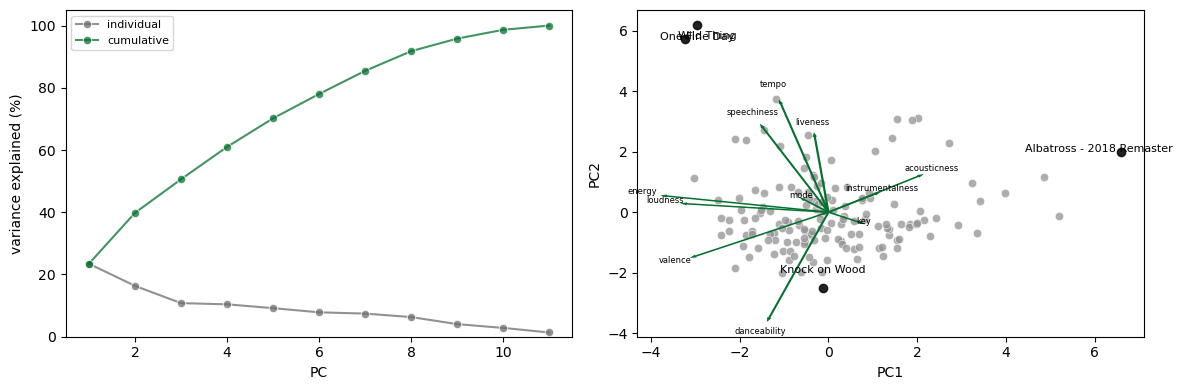

In [13]:
# Plot
pcs1960 = plot_pca_and_var_exp(df_csv, features, decade=60, c1=0, c2=1, t=0.8)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.4 Individual Variance Cumulative Variance of PCs '
             'for 1960 (left) <br>Figure 5.5 Scatter Plot of Songs to PC1 '
             'and PC2 with Loadings Plot for songs in 1960 (right)'
             '</b></center>'))

<div style='text-align: justify;'> For the 1960's, we plotted the individual PCs and the cumulative PCs on <b>Figure 5.4</b>. Similarly, we can see that we can use 7 PCs to account for at least 80% of the variance of the total data set. We can also see the scatter plot of the data mapped into the first 2 PCs in <b>Figure 5.5</b> with the loadings plot.</div>

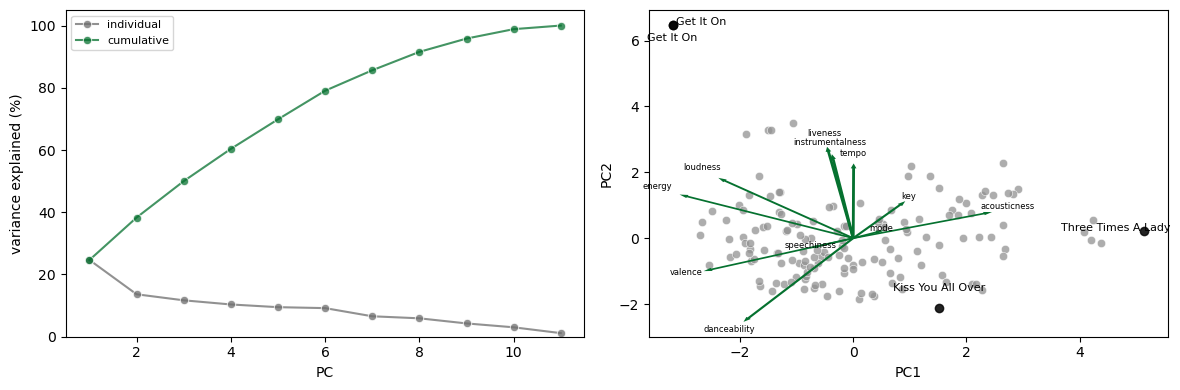

In [14]:
# Plot
pcs1970 = plot_pca_and_var_exp(df_csv, features, decade=70, c1=0, c2=1, t=0.8)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.6 Individual Variance Cumulative Variance of PCs '
             'for 1970 (left) <br>Figure 5.7 Scatter Plot of Songs to PC1 '
             'and PC2 with Loadings Plot for songs in 1970 (right)'
             '</b></center>'))

<div style='text-align: justify;'> In the 1970's, the individual PCs and the cumulative PCs were plotted on <b>Figure 5.6</b>. 7 PCs account for at least 80% of the variance of the total data set. The scatter plot show s the data mapped into the first 2 PCs in <b>Figure 5.7</b>.</div>

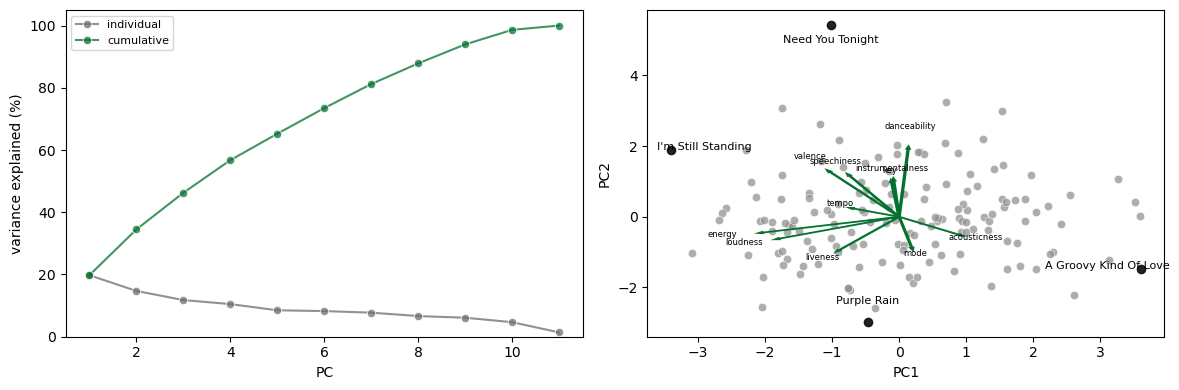

In [15]:
# Plot
pcs1980 = plot_pca_and_var_exp(df_csv, features, decade=80, c1=0, c2=1, t=0.8)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.8 Individual Variance Cumulative Variance of PCs '
             'for 1980 (left) <br>Figure 5.9 Scatter Plot of Songs to PC1 '
             'and PC2 with Loadings Plot for songs in 1980 (right)'
             '</b></center>'))

<div style='text-align: justify;'> For the 1980's, we also plotted the individual PCs and the cumulative PCs as seen on <b>Figure 5.8</b>. 7 Principal Components account for at least 80% of the variance of the total data set. The scatter plot of the data mapped into the first 2 PCs is depicted in <b>Figure 5.9.</b></div>

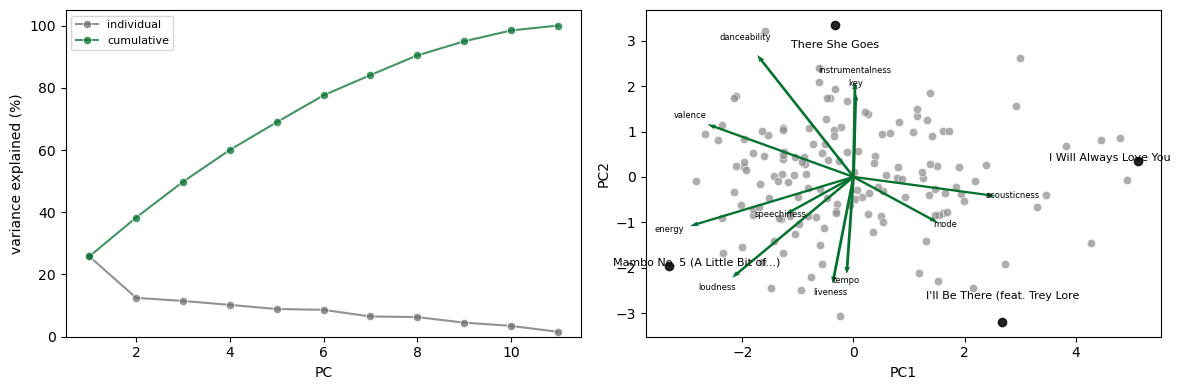

In [16]:
# Plot
pcs1990 = plot_pca_and_var_exp(df_csv, features, decade=90, c1=0, c2=1, t=0.8)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.10 Individual Variance Cumulative Variance of PCs '
             'for 1990 (left) <br>Figure 5.11 Scatter Plot of Songs to '
             'PC1 and PC2 with Loadings Plot for songs in 1990 (right)'
             '</b></center>'))

<div style='text-align: justify;'> For the 1990's, we plotted the individual PCs and the cumulative PCs on <b>Figure 5.10</b>. It can be seen that we used 7 PCs to account for at least 80% of the variance. The loadings plot also depictss data mapped into the first 2 PCs in <b>Figure 5.11</b>.</div>

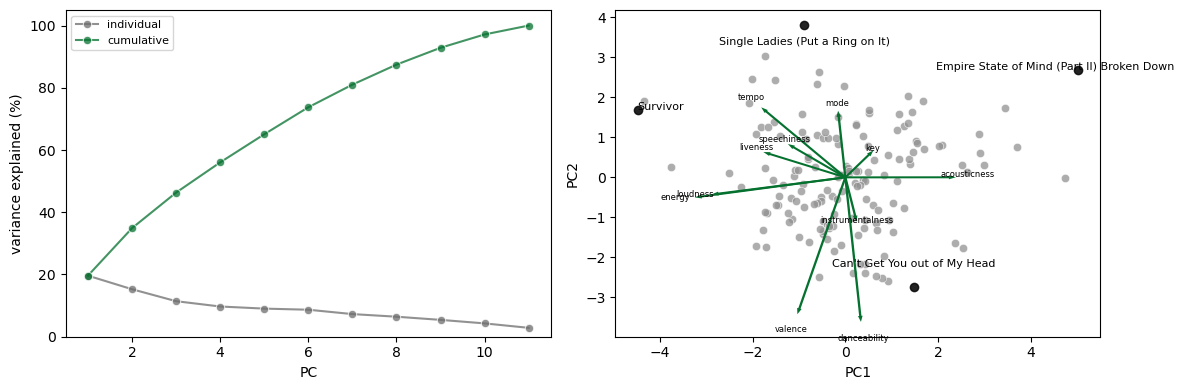

In [17]:
# Plot
pcs2000 = plot_pca_and_var_exp(df_csv, features, decade=0, c1=0, c2=1, t=0.8)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.12 Individual Variance Cumulative Variance of PCs '
             'for 2000 (left) <br>Figure 5.13 Scatter Plot of Songs to PC1 '
             'and PC2 with Loadings Plot for songs in 2000 (right)'
             '</b></center>'))

<div style='text-align: justify;'> Similarly for the 2000's, individual and cumulative PCs were pltotted on Figure <b>5.12</b>. Here we can see that we also used 7 PCs to account for at least 80% of the variance of the total data set. The scatter plot of the data mapped into the first 2 PCs as seen in <b>Figure 5.13</b>, the loadings plot.</div>

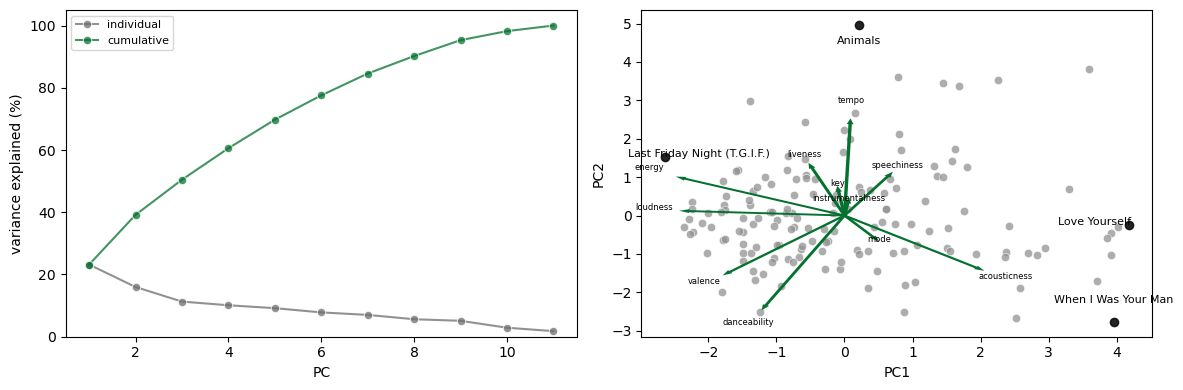

In [18]:
# Plot
pcs2010 = plot_pca_and_var_exp(df_csv, features, decade=10, c1=0, c2=1, t=0.8)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.14 Individual Variance Cumulative Variance of PCs '
             'for 2010 (left) <br>Figure 5.15 Scatter Plot of Songs to PC1 '
             'and PC2 with Loadings Plot for songs in 2010 (right)'
             '</b></center>'))

<div style='text-align: justify;'> For the 2010's, we plotted the Principal Components to account for 80% explained variance as see on <b>Figure 5.14</b>.  We can also see the scatter plot of the data mapped into the first 2 PCs in <b>Figure 5.15. </b></div>

<div style='text-align: justify;'> We assessed the top features that impacted each Principial Component Analysis. For this section, we only analyzed the first two PCs which explains 80% variability of the total dataset. We performed the analysis for each decade. We then plotted the features with their corresponding weights and arranged them in decreasing absolute magnitude. The reference code is shown below and the respective analysis per decade is accompanied by <b>Figures 5.16 to 5.22.</b></div>

In [19]:
def pca_weights(df, features, decade=None, n_features=11):
    """Plots bar graph containing top features influencing the PCs

    Parameters
    ----------
    df : pandas DataFrame
        df for processing
    features : list
        list of feature_names for bar plot
    top_n : int, optional
        number pf PCs to be graphed
    n_features : int, optional
        number of features to be plot on each bar graph
    """

    # filter df for analysis
    df_filtered, songs, artists, feature_names = build_df(df,
                                                          features,
                                                          decade=decade)
    # Standardize input pandas DataFrame
    X = df_filtered.to_numpy()
    X_std = (X - X.mean(axis=0))/X.std(axis=0)
    pca = decomposition.PCA()
    X_std_PCA = pca.fit_transform(X_std)
    p = pca.components_.T

    fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), dpi=100)

    for PC in range(2):
        order = np.argsort(np.abs(p[:, PC]))[-1*n_features:]
        ax.flatten()[PC].barh([feature_names[o] for o in order], p[order, PC],
                      color='forestgreen')
        ax.flatten()[PC].tick_params(labelsize=8)
        ax.flatten()[PC].set_title(f'PC{PC+1}', size=10)
        ax.flatten()[PC].set_xlim(-0.65, 0.65)
        ax.flatten()[PC].spines['top'].set_visible(False)
        ax.flatten()[PC].spines['bottom'].set_visible(False)
        ax.flatten()[PC].spines['left'].set_visible(False)
        ax.flatten()[PC].spines['right'].set_visible(False)
        ax.flatten()[PC].tick_params(which='both', width=0)    
    plt.show()

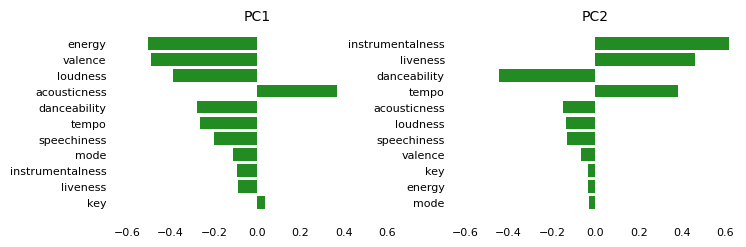

In [20]:
pca_weights(df_csv, features, decade=50, n_features=len_features)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.16 Principal Components 1 and 2 with Top Features '
             ' for songs in 1950</b></center>'))

<div style='text-align: justify;'> For the 1950's, we see in <b>Figure 5.16</b> that the highest features impacting PC1 are energy, valence, and loudness, which are all pointed in the same direction. Given that they are in the same negative magnitude, this also implies that the three are correlated. The next highest contributor to PC1 would be acousticness but it is negatively correlated with the first three PCs having a positive PC1 value. Additionally, danceability, tempo, speechiness and the rest of the features are also negatively correlated with acousticness. This PC can describe the nature of how the song was produced: whether it was acoustic or not.</div>
<br>

<div style='text-align: justify;'> For the second PC in <b>Figure 5.16</b>, the feature with highest contribution is instrumentalness, followed by liveness which are both correlated. Danceability comes next but is negatively correlated to the first two. Tempo follows as the fourth highest but is correlated with the first two features. This PC can describe whether the song is danceable or not. However, the definition of danceability here is the low usage of instruments and low live vocals or audiences.</div>

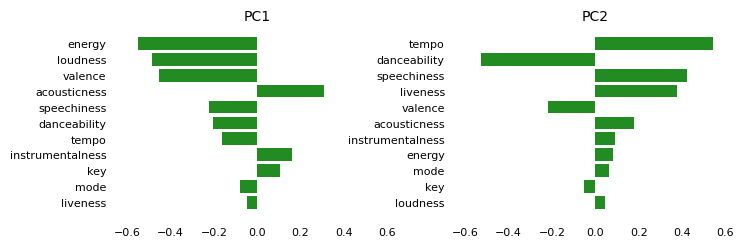

In [21]:
pca_weights(df_csv, features, decade=60, n_features=len_features)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.17 Principal Components 1 and 2 with Top Features '
             ' for songs in 1960</b></center>'))

<div style='text-align: justify;'> For the 1960's, we see in <b>Figure 5.17</b> that the highest features impacting PC1 are energy, valence, and loudness again with all being correlated with each other. Next highest contributor to PC1 would be acousticness and is also negatively correlated with the first three PCs. This Principal Component can also describe the nature of how the song was produced: whether it was acoustic or not for the 1960's.</div>
<br>

<div style='text-align: justify;'> For the second PC in <b>Figure 5.17</b>, the feature with highest contribution is tempo. It is followed by danceability which is negatively correlated tp tempo. The next two are speechiness and liveness as well and are also correlated  with tempp. Similar to 1950's, this second PC can describe whether a song is danceable or not. </div>

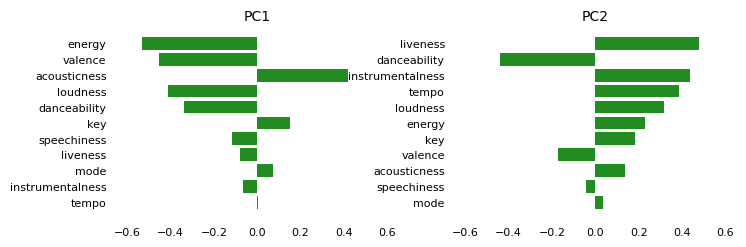

In [22]:
pca_weights(df_csv, features, decade=70, n_features=len_features)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.18 Principal Components 1 and 2 with Top Features '
             ' for songs in 1970</b></center>'))

<div style='text-align: justify;'> In the 1970's, we see in <b>Figure 5.18</b> that the highest features impacting PC1 are energy and valence; while loudness becomes fourth. Danceability also emerges as a strong 5th PC. Likewise, acousticness is still the 3rd highest feature for this PC and is still negatvely correlated with the other four features mentioned above. This PC again describes the nature how the song was produced: whether it was acoustic or not.</div>
<br>

<div style='text-align: justify;'> For the second PC in <b>Figure 5.18</b>, the highest contributing feature would now become liveness. The same set of features contribute next with liveness, instrumentalness, tempo, loudness, being correlated to it. Danceability again is the feature that is negatively correlated with these other features with high contribution to this PC.</div>

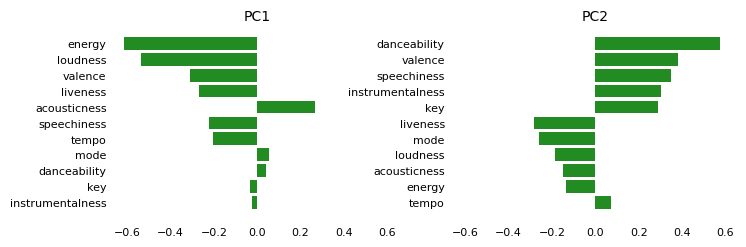

In [23]:
pca_weights(df_csv, features, decade=80, n_features=len_features)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.19 Principal Components 1 and 2 with Top Features '
             ' for songs in the 1980s </b> </center>'))

<div style='text-align: justify;'> In the 1980's, <b>Figure 5.19</b> shows that the same set of features contributing to PC1 the highest: energy, loudness, valence and liveness. Acousticness is demoted to the fifth highest feature and is still negatively correlated with the other features. This PC again describes the nature how the song was produced: whether it was acoustically or not.</div>
<br>

<div style='text-align: justify;'> For the second PC in <b>Figure 5.19</b>, we see a change that danceability is now the highest feature contributing to the PC and is now correlated with the other top features such as valence, speechiness, instrmentalness. The feature key also emerges. The feature would now be about the verbosity or the sound of the song while being danceable. This verbosity does not equate to loudness.</div>

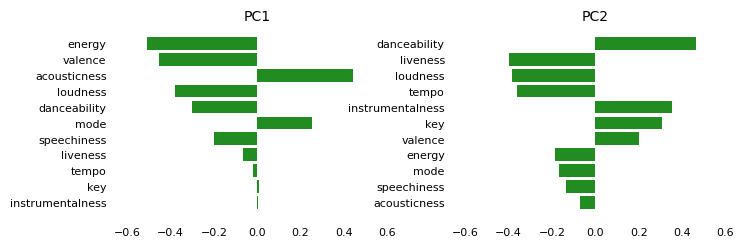

In [24]:
pca_weights(df_csv, features, decade=90, n_features=len_features)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.20 Principal Components 1 and 2 with Top Features '
             ' for songs in the 1990s</b></center>'))

<div style='text-align: justify;'> For the 1990's, we see in <b>Figure 5.20</b> again energy, valence, loudness and danceability forming one group of features and acousticness on the other side. This PC again describes the nature how the song was produced: whether it was acoustically or not.</div>
<br>

<div style='text-align: justify;'> For the second PC in <b>Figure 5.20</b> that danceability is again the highest feature contributing to the PC but is now uncorrelated with the next three features: liveness, loudness and tempo. Loudness emerges as a stronger feature for this decade compared to other decades. Danceability now becomes correlated with instrumentalness. The feature can be about using instruments as a way to make the listener dance that emerges in this decade.</div>

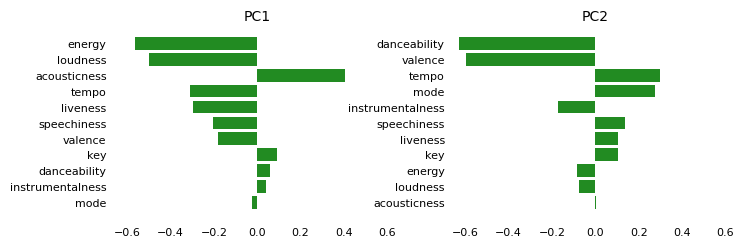

In [25]:
pca_weights(df_csv, features, decade=0, n_features=len_features)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.21 Principal Components 1 and 2 with Top Features '
             ' for songs in the 2000s</b></center>'))

<div style='text-align: justify;'> In the 2000's, we see in <b>Figure 5.21</b> a shift in features for PC1. Energy and loudness are still highly contributing to PC1, with acousticness as the 3rd negatively corrlated feature. However, valence is now 8th in importance for this PC. Other features that are correlated with energy and loudness are tempo, liveness, and speechiness. This PC again describes the nature pf how the song was produced: whether it was acoustic or not.</div>
<br>

<div style='text-align: justify;'> For the second PC in <b>Figure 5.21</b>, danceability again is the highest feature contributing to the PC but valence becomes the 2nd highest feature and is correlated with danceability. The next features are tempo and mode, both negatively correlated with the first two features. This PC can be about songs with high valence or high positive messages being danceable as well. These two features are negatively correlated to tempo, so it is not necessary that a danceable song is fast for this decade.</div>

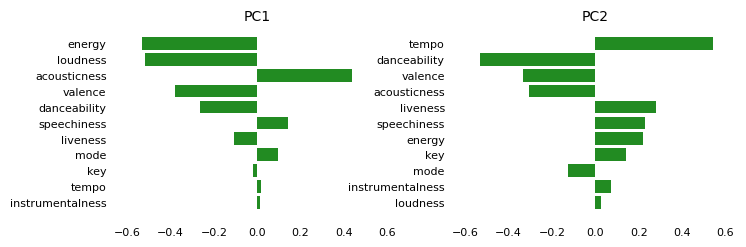

In [26]:
pca_weights(df_csv, features, decade=10, n_features=len_features)
display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.22 Principal Components 1 and 2 with Top Features '
             ' for songs in the 2010s</b></center>'))

<div style='text-align: justify;'> For the 2010's, we see in <b>Figure 5.22</b>that energy and loudness are still highly contributing to PC1, with acousticness as the 3rd negatively corrlated feature yet again. Valence returns as a high contributor being the 4th highest in value. This PC again describes the nature how the song was produced: whether it was acoustic or not
For the second PC in <b>Figure 5.22</b>, tempo becomes the highest feature. However, the next features danceability, valence, and acousticness become negatively correlated with tempo. This PC can be danceability of slower songs having high acousticness and valence.</div>

<div style='text-align: justify;'> To summarize for <b>PC1</b>, we see it about acousticness against energy, loudness and valence for most of the decades. Liveness became prominent in 1980's, danceability in 1970's and 1990's and 2010's, tempo in 2000's. For the second PC <b>(PC2)</b>, it was about danceability against other features such as tempo and liveness. However danceability becomes correlated with the other top features in 1980's. Features that emerged also and became correlated with danceability are instrumentalness for 1990's, valence for 2000's and valence and acousticness for the 2010's.</div>

### 5.3 Clustering
<br>

<div style='text-align: justify;'>Each decade was clustered separately taking into consideration criteria like separation, balance, compactness, and the least possible number of clusters. Internal validation metrics were also considered in choosing the appropriate number of clusters. Each cluster was then described based on the mean features that distinguish or liken them to one another. </div>

### 1950's
<br>

<div style='text-align: justify;'>For the 1950's, the team selected three clusters based on the results of the Silhouette and SSE validation tests. The Silhouete coefficient has the highest value for <b>k = 3</b> and this is where the elbow of the SSE plot can be found. The gap statistics value was also the highest among the lower numbered k values. Based on the scatter plot, the separation of the clusters is clear while the clusters are moderately compact. There is more balance between cluster 1 and 2 while there are fewer data points found in cluster 0.</div>

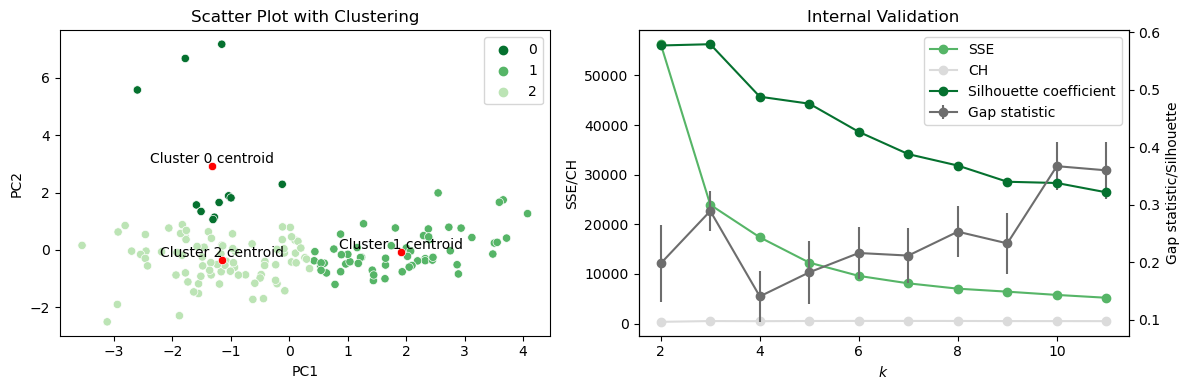

In [27]:
# plot clustering scatter plot and internal validation chart
y_predict, X_std = k_means_test(df_csv, features, decade=50, k=3, 
                                pc=7, plot=True, 
                                clusterer=KMeans(random_state=1337), 
                                k_start=2, k_end=11, actual=None)

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.23 Cluster Scatter Plot and Internal '
             'Validation Chart for the 1950s </b></center>'))

<div style='text-align: justify;'>These are the clusters formed based on the Scatter Plot <b> (Figure 5.23)</b>:</div><br>

<div style='text-align: justify;'><b>Cluster 0</b> - Songs in this cluster have high energy, tempo valance, and liveness but are relatively low in danceability. For the sake of discussion we can place this cluster in group A.</div>
<br>
<div style='text-align: justify;'><b>Cluster 1</b> - The songs in this cluster have the highest acousticness while having the lowest valence, tempo, loudness, and energy. This cluster belongs to group B.</div>
<br>
<div style='text-align: justify;'><b>Cluster 2</b> - Songs are almost the same as cluster 0 but with lower tempo and higher in danceability. We can put this cluster in group C.</div>

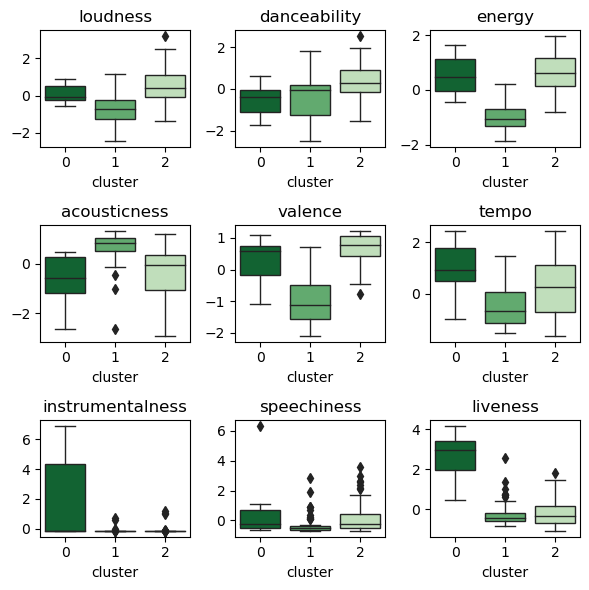

In [28]:
# plot audio feature boxplot for the decade
boxplot(X_std, 50);

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.24 Audio Features per Cluster in the 1950s '
             '</b></center>'))

### 1960's
<br>

<div style='text-align: justify;'>The team selected two clusters forfor the 1960's based on the results of the Silhouette validation tests. The Silhouete coefficient is the highest for <b>k = 2</b>. The gap statistics value was also the highest among the lower numbered k values. Based on the scatter plot, the separation of the clusters is clear. Cluster 0 seems to have more datapoints compared to Cluster 1.</div>

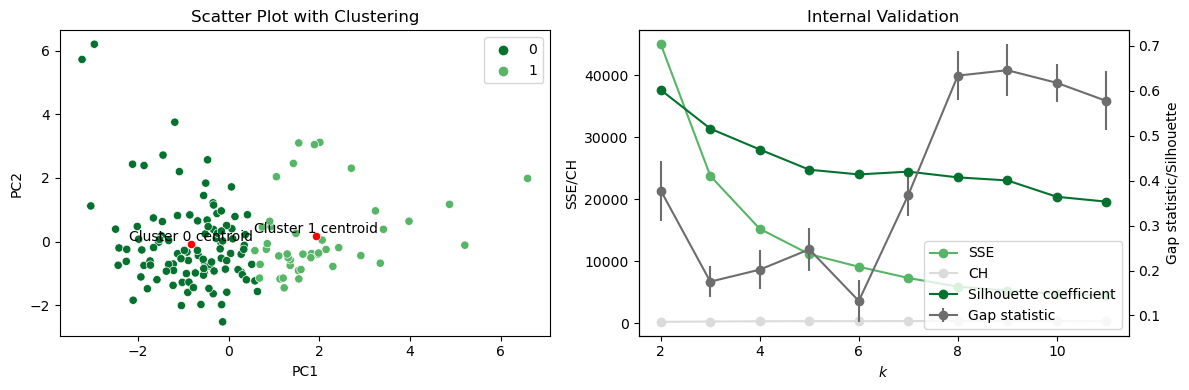

In [29]:
# plot clustering scatter plot and internal validation chart
y_predict, X_std = k_means_test(df_csv, features, decade=60, k=2, 
                                pc=7, plot=True, 
                                clusterer=KMeans(random_state=1337), 
                                k_start=2, k_end=11, actual=None)


display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.25 Cluster Scatter Plot and Internal '
             'Validation Chart in the 1960s</b></center>'))

<div style='text-align: justify;'>Clusters formed based on the Scatter Plot <b> (Figure 5.25)</b>:</div><br>

<div style='text-align: justify;'><b>Cluster 0</b> - Comparing the two clusters, the songs here have higher loudness, energy valence and moderate danceability. Like in th 1950's, this can be considered as a part of group A.</div>
<br>
<div style='text-align: justify;'><b>Cluster 1</b> - Meanwhile, songs in this cluster are the opposite with acousticness as its most notable feature, same as the songs in the previous set of clusters in group B.</div>

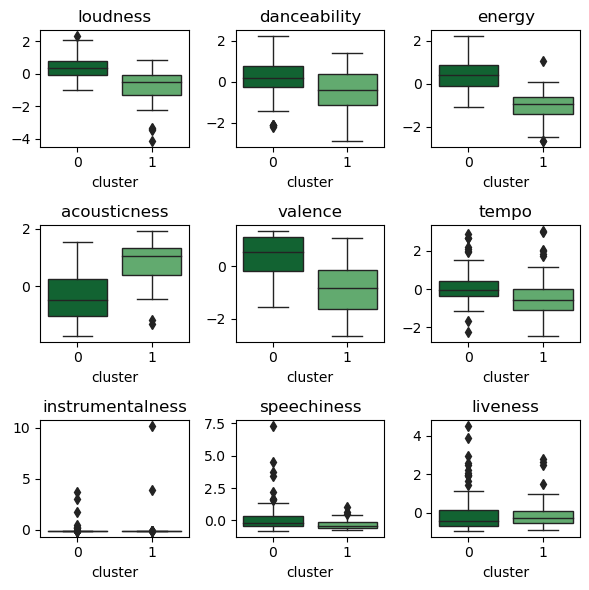

In [30]:
# plot audio feature boxplot for the decade
boxplot(X_std, 60);

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.26 Audio Features per Cluster in the 1960s'
             '</b></center>'))


### 1970's
<br>

<div style='text-align: justify;'>For the 1970's, two clusters were also selected based on the results of the Silhouette validation tests with the coefficient being the highest at <b>k = 2</b>. The gap statistics value was also the highest among the lower numbered k values. The separation of the clusters is clear based on the scatter plot. Cluster 0 and 1 seem to be balanced in terms of number of data points.</div>

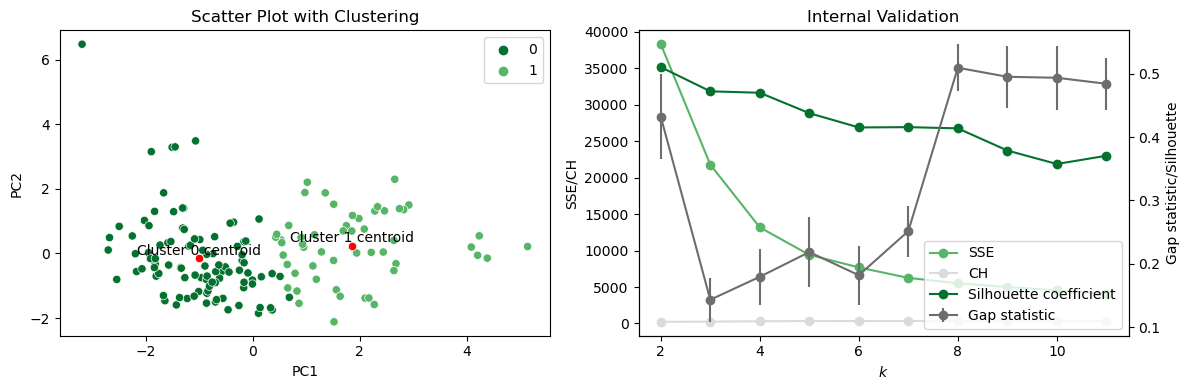

In [31]:
# plot clustering scatter plot and internal validation chart
y_predict, X_std = k_means_test(df_csv, features, decade=70, k=2, 
                                pc=7, plot=True, 
                                clusterer=KMeans(random_state=1337), 
                                k_start=2, k_end=11, actual=None)

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.27 Cluster Scatter Plot and Internal '
             'Validation Chart in the 1970s</b></center>'))

<div style='text-align: justify;'>Clusters formed based on the Scatter Plot <b> (Figure 5.27)</b>:</div><br>

<div style='text-align: justify;'><b>Cluster 0</b> - Same as the 50's, the songs in this cluster have higher loudness, danceability, energy and valence. The danceability is the most telling  feature for this cluster which makes it a part of group C.</div>
<br>
<div style='text-align: justify;'><b>Cluster 1</b> - Meanwhile, songs in this other cluster are the opposite of the first cluster, with acousticness as the most notable feature. This is consistent with the slow and mellow type of songs found in the 1950's and 1960's, particularly in group B.</div>

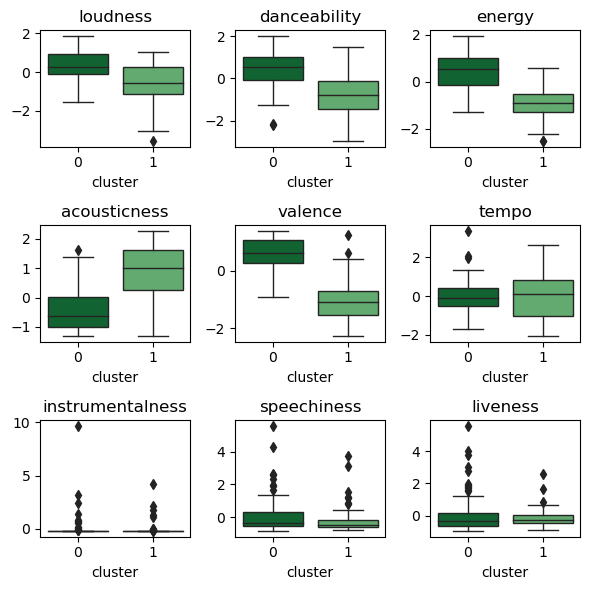

In [32]:
# plot audio feature boxplot for the decade
boxplot(X_std, 70);

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.28 Audio Features per Cluster in the 1970s'
             '</b></center>'))

### 1980's
<br>

<div style='text-align: justify;'>Two clusters based on the results of the Silhouette validation tests were selected for the 1980's. The Silhouete coefficient is the highest for <b>k = 2</b>. Based on the scatter plot, the separation of the clusters is mostly clear except for a few overlaps. Cluster 0 and 1 also seem to be balanced in terms of the number of data points.</div>

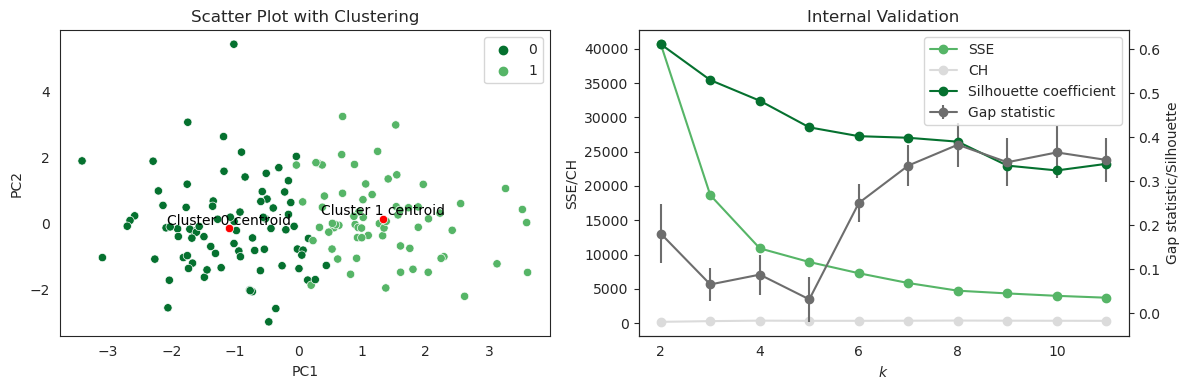

In [53]:
# plot clustering scatter plot and internal validation chart
y_predict, X_std = k_means_test(df_csv, features, decade=80, k=2, 
                                pc=7, plot=True, 
                                clusterer=KMeans(random_state=1337), 
                                k_start=2, k_end=11, actual=None)


display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.29 Cluster Scatter Plot and Internal '
             'Validation Chart in the 1980s </b></center>'))

<div style='text-align: justify;'>Formed cluster from the Scatter Plot <b> (Figure 5.29)</b>:</div><br>

<div style='text-align: justify;'><b>Cluster 0</b> - The songs in this cluster have higher loudness, energy, and valence. Meanwhile they are comparable in terms of danceability and tempo. Consistent with the upbeat and danceable hits from the previous decades, it has same the characteristics with clusters in group C.</div>
<br>
<div style='text-align: justify;'><b>Cluster 1</b> - Acousticness remains the most noteworth feature in this cluster while it has lower energy, valencem and loudness. It is noticaeable though that this cluster has a higher danceability compared to the usual slow songs we saw in the previous decades. We can create a new group with this type of music, group D.</div>

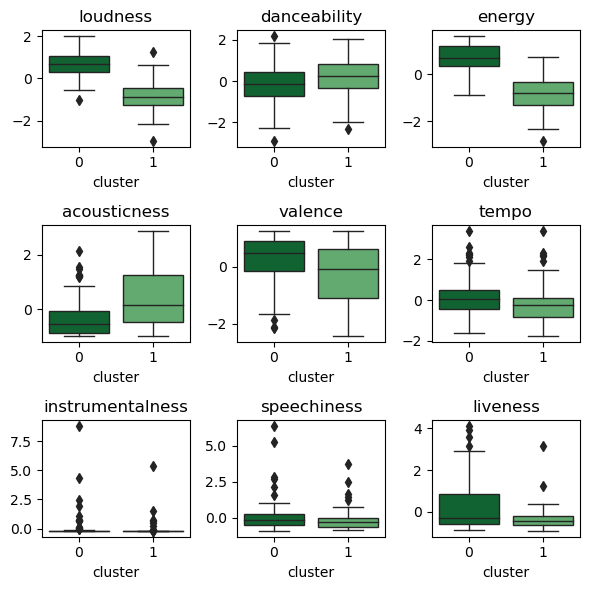

In [34]:
# plot audio feature boxplot for the decade
boxplot(X_std, 80);

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.30 Audio Features per Cluster in the 1980s'
             '</b></center>'))

### 1990's
<br>

<div style='text-align: justify;'>For the 1990's, the group selected three clusters based on the results of the Silhouette and SSE validation tests. The Silhouete coefficient has the highest value for <b>k = 3</b>, where the elbow of the SSE plot is also found. The gap statistics value was the highest among the lower numbered k values. Based on the scatter plot, the separation of the clusters is somewhat clear with overlaps between cluster 1 and 2. Meanwhile, the clusters are moderately compact. The number of data points per cluster are moderately balanced.</div>

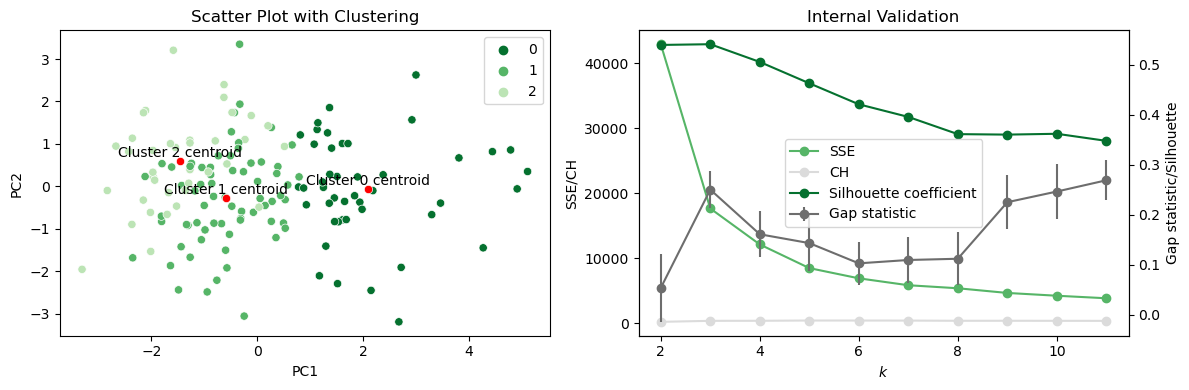

In [35]:
# plot clustering scatter plot and internal validation chart
y_predict, X_std = k_means_test(df_csv, features, decade=90, k=3, 
                                pc=7, plot=True, 
                                clusterer=KMeans(random_state=1337), 
                                k_start=2, k_end=11, actual=None)


display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.31 Cluster Scatter Plot and Internal '
             'Validation Chart in the 1990s </b></center>'))

<div style='text-align: justify;'>Clusters formed from the Scatter Plot <b> (Figure 5.31)</b>:</div><br>

<div style='text-align: justify;'><b>Cluster 0</b> - The songs in this cluster have characteristically low energy, danceability and valence while having high acousticness. We see the return of this type of cluster for the 1990's, which is the same as those found in group B.</div>
<br>
<div style='text-align: justify;'><b>Cluster 1</b> - Meanhwile, the songs in this cluster are comparable with cluster 2 in terms of high loudness and valence. It exhibits high energy and moderate danceability. This cluster can be included in group A.</div>
<br>
<div style='text-align: justify;'><b>Cluster 2</b> - Songs in this cluster have the highest loudness, danceability and valence but are low in acousticness.  All three clusters are comparable in terms of tempo. The high loudenss and danceability is consistent with one of our cluster groups, group C.</div>

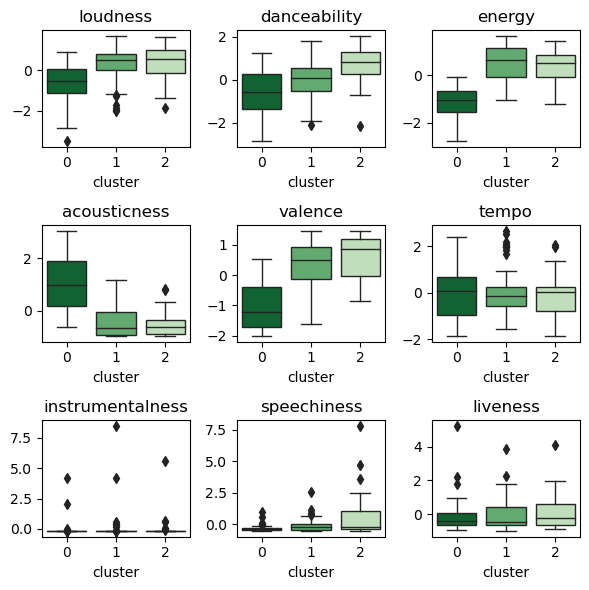

In [36]:
# plot audio feature boxplot for the decade
boxplot(X_std, 90);

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.30 Audio Features per Cluster  in the 1990s'
             '</b></center>'))


### 2000's
<br>

<div style='text-align: justify;'> Three clusters were formed based on the results of the Silhouette and SSE validation tests. The Silhouete coefficient is the highest for <b>k = 3</b>. Similarly, this is also where the elbow of the SSE plot is found. The gap statistics value was also the highest. Based on the scatter plot, the separation of the clusters is clear and the clusters are moderately compact. There is more balance between cluster 0 and 1 while there are fewer data points found for cluster 2.</div>

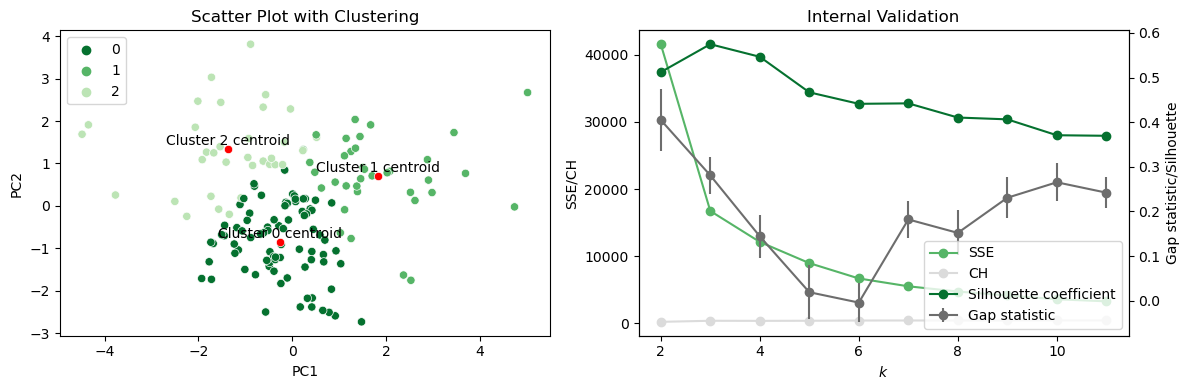

In [37]:
# plot clustering scatter plot and internal validation chart
y_predict, X_std = k_means_test(df_csv, features, decade=0, k=3, 
                                pc=7, plot=True, 
                                clusterer=KMeans(random_state=1337), 
                                k_start=2, k_end=11, actual=None)


display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.33 Cluster Scatter Plot and Internal '
             'Validation Chart in the 1990s </b></center>'))


<div style='text-align: justify;'>Clusters formed based on the Scatter Plot <b> (Figure 5.33)</b>:</div><br>

<div style='text-align: justify;'><b>Cluster 0</b> - Songs in this cluster have high and danceability. They also show comparably high values for energy and loudness as cluster 2. Most of the features point to the danceable tracks that we can find the in cluster group C.</div>
<br>
<div style='text-align: justify;'><b>Cluster 1</b> - The songs in this cluster have the highest acousticness while having the lowest valence, tempo, loudness, and energy. These are the same with other slow and mellow songs in group B.</div>
<br>
<div style='text-align: justify;'><b>Cluster 2</b> - Songs here are almost the same in cluster 0 but with higher tempo, energy and loudness. It also has low danceability and varying levels of speechiness and liveness. This is a new type of cluster which includes higher tempo and energy but with low danceability. It also has a valence comparable to our sad and mellow songs. This cluster can be placed in group E.</div>

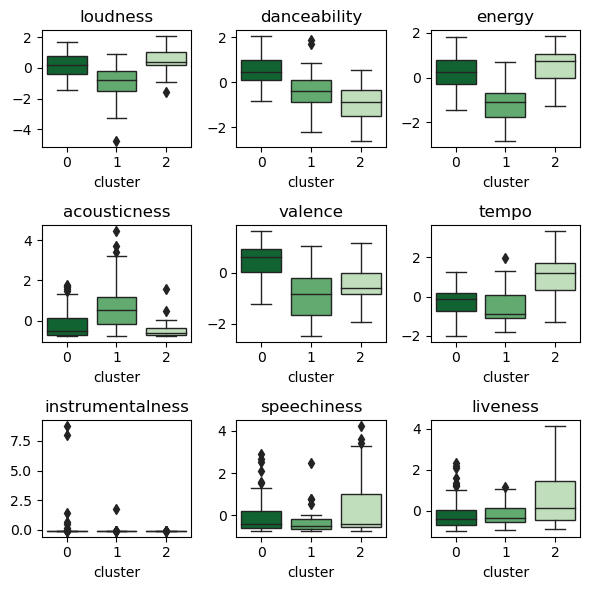

In [38]:
# plot audio feature boxplot for the decade
boxplot(X_std, 0);

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.34 Audio Features per Cluster in the 2000s'
             '</b></center>'))


### 2010's
<br>

<div style='text-align: justify;'>For the 2010's, the team initially selected three clusters based on the results of the Silhouette and SSE validation tests. The Silhouete coefficient is the highest for <b>k = 3</b> and this is also were the elbow of the SSE plot is found. This clustering yielded two large clusters and one micro cluster with less than 5 data points. We then tried 4 clusters since it had the highest gap statistic value. Based on the scatter plot, the separation of the clusters is clear execpt for Cluster 0 which remains as a microcluster. Clusters are not compact and are slightly more scattered.</div>

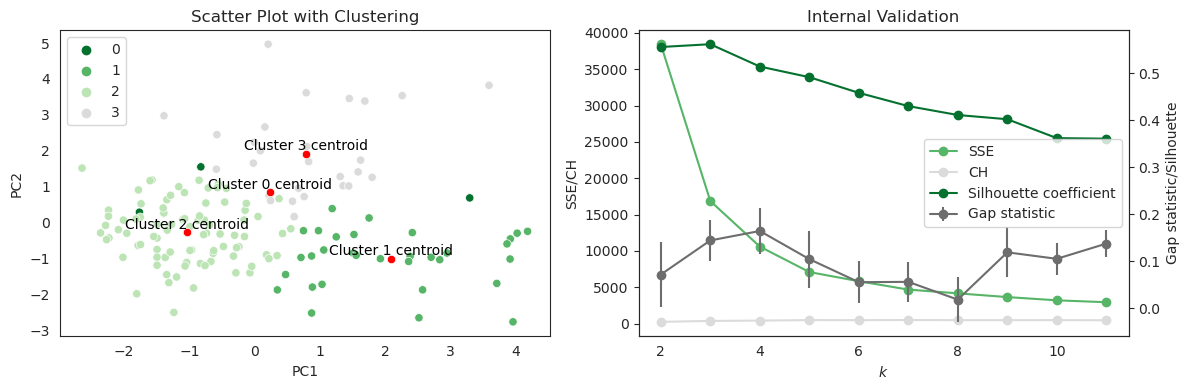

In [49]:
# plot clustering scatter plot and internal validation chart
y_predict, X_std = k_means_test(df_csv, features, decade=10, k=4, 
                                pc=7, plot=True, 
                                clusterer=KMeans(random_state=1337), 
                                k_start=2, k_end=11, actual=None)

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.35 Cluster Scatter Plot and Internal '
             'Validation Chart in the 2010s</b></center>'))

<div style='text-align: justify;'> Formed clusters from the Scatter Plot <b> (Figure 5.35)</b>:</div><br>

<div style='text-align: justify;'><b>Cluster 0</b> - The songs here are outliers, notably due to their high instrumentalness. </div>
<br>
<div style='text-align: justify;'><b>Cluster 1</b> - Songs in this cluster have low energy, tempo, and loudness but have high acousticness. These songs have moderate danceability compared to the other clusters. Their likeness to the unique 1980's cluster is notable. We can place this cluster in group D.</div>
<br>
<div style='text-align: justify;'><b>Cluster 2</b> - Meanwhiles, songs in this cluster have the highest loudness, danceability, energy, and valence. This type of cluster is one of the most common type of clusters through the decades and also belongs to group C.</div>
<br>
<div style='text-align: justify;'><b>Cluster 3</b> - Songs found in this cluster have high tempo, with comparably high energy and loudness but they score low in valence and danceability. Consistent with the newly formed cluster group in the 2000's, this also belongs to group E.</div>

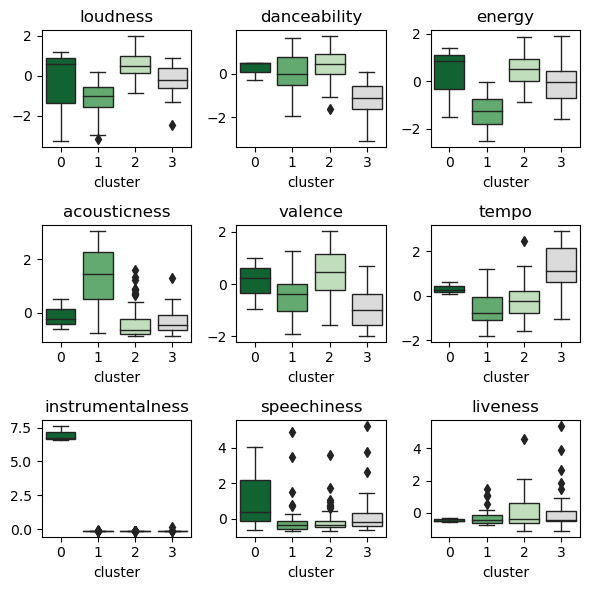

In [40]:
# plot audio feature boxplot for the decade
boxplot(X_std, 10);

display(HTML('<center style="font-size:14px;font-style:default;">'
             '<b>Figure 5.36 Audio Features per Cluster in the 2010s'
             '</b></center>'))

<div style='text-align: justify;'>As a summary, we classified the clusters found in each decade using the prominent features that they have. We were able to identify five unique groups. Group A was characterized by high energy, tempo and valence but with low danceability. Clusters are found in the 1950's, 1960's, and 1990's. Meanwhile Group B which includes more mellow songs had acousticness as it most notable feature, combined with low valence, loudness, energy, and danceability. These clusters can be found in the 1950's, 1960's, 1970's, 1990's and 2000's. </div><br>
    
<div style='text-align: justify;'>Group C is the total opposite of group B, known for songs with high energy, loudness, valence, and danceability as well as low acousticness. It is present in all decades except for the 1960's. Meanwhile, group D is similar to the mellow song of group B but are more danceable than usual. These clusters were found in the 1980's and 2010's. Finally, we have group E, the latest group which showed up in the 2000's and is composed of songs with high loudness, energy, and tempo but with a lower valence. It is present up to the 2010's.</div>

### 5.4 Cluster Description, Labeling, and Interpretation

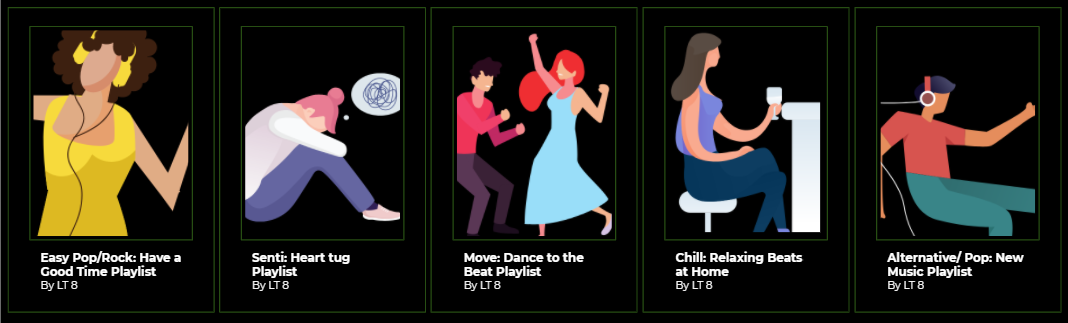

<div style="text-align: justify">The clusters formed in the previous section were labeled according to the levels of their defining audio features. For example, <b>Cluster 1</b> from the 50's that had low values for loudness, danceability, energy, and valence, with value for acousticness labeled as <b>'Senti'</b> had a general description of having sentimental, mellow songs. This labeling was further supported by checking random song samples from the cluster formed to verify that the song follows the general description for the cluster.</div><br>

<div style="text-align: justify">After all of the clusters from the different decades were assessed for their defining audio features, notable similarities across decades surfaced. Clusters with similar defining audio features were labeled the same. For example, Cluster 1 that emerged in the 60's that also had relatively low values for loudness, danceability, energy and valence, and high value for acousticness, was also labeled <b>'Senti'</b> just like Cluster 1 in the 50's.</div><br>

<div style="text-align: justify"><b>Finally, after assessment and comparison of the clusters, five unique labels emerged.</b> The songs from the similar clusters across the decades were essentially clustered together. Each final cluster is described in the table below and contains the label, the matching cluster groups, general description, and a summary of its defining features. Each cluster will be further described in the following sections.</div>

<br>
<center style="font-size:14px;font-style:default;"><b>Table 5.1 Cluster Label and Description</b></center>

| Cluster Label   | Matching Cluster Groups | General Description                     | Defining Features                                                         |
|:----------------| :---------------: |:----------------------------------------|:-------------------------------------------------------------------------|
| Easy Pop/Rock   | A | Happy, upbeat, easy listening songs     | High: Energy, Valence, Tempo<br>Low: Danceability, Acousticness           |
| Senti           | B | Sentimental, mellow songs               | High: Acousticness<br>Low: Loudness, Danceability, Energy, Valence        |
| Move            | C | Happy, energetic dance songs            | High: Loudness, Danceability, Energy, Valence<br>Low: Acousticness        |
| Chill           | D | Sentimental, mellow dance songs         | High: Danceability, Acousticness<br>Low: Loudness, Energy, Valence, Tempo |
| Alternative Pop | E | Sentimental, upbeat and energetic songs | High: Loudness, Energy, Tempo<br>Low: Danceability, Acousticness, Valence |

In [41]:
# Prepare dataframe with Cluster_Label column
df_all = pd.DataFrame()

# Mapping of Cluster Labels
dec50map = {0: 'Easy Pop/Rock', 1: 'Senti', 2: 'Move'}
dec60map = {0: 'Easy Pop/Rock', 1: 'Senti'} 
dec70map = {0: 'Move', 1: 'Senti'}
dec80map = {0: 'Move', 1: 'Chill'}
dec90map = {0: 'Senti', 1: 'Easy Pop/Rock', 2: 'Move'}
dec00map = {0: 'Move', 1: 'Senti', 2: 'Alternative/Pop',}
dec10map = {0: 'Outlier', 1: 'Chill', 2: 'Move', 3: 'Alternative/Pop'}

mapping = [dec50map, dec60map, dec70map, dec80map, dec90map,
           dec00map, dec10map]

# Iterate numper of PCs, clusters and label per cluster per decade
for decade, cluster_count, pc_count, map_val in zip(decade_list,
                                                    clusters_per_decade,
                                                    pcs_per_decade,
                                                    mapping):

    # Build the dataframe according to necessary filters
    df_filtered, songs, artists, feature_names = build_df(df_csv,
                                                          features,
                                                          decade=decade)
    # Get centers and processed design matrix
    y_kmeans, X_std = k_means_test(df_csv, features, decade=decade,
                                   k=cluster_count,
                                   pc=pc_count,
                                   plot=False)

    # Build DataFrame with additional relevant features 
    df_with_cluster_kmeans = pd.concat([df_filtered.reset_index(), 
                                        pd.DataFrame(songs, 
                                                     columns=['song']),
                                        pd.DataFrame(artists,
                                                     columns=['artist']),
                                        pd.DataFrame(y_kmeans,
                                                     columns=['cluster'])],
                                       axis=1)

    df_with_cluster_kmeans.drop(columns='index', inplace=True)
    df_with_cluster_kmeans['decade'] = decade
    df_with_cluster_kmeans['cluster_label'] = (df_with_cluster_kmeans
                                               ['cluster'].map(map_val))

    # Append for all decades and resulting clusters
    df_all = df_all.append(df_with_cluster_kmeans)

## Easy Pop/Rock

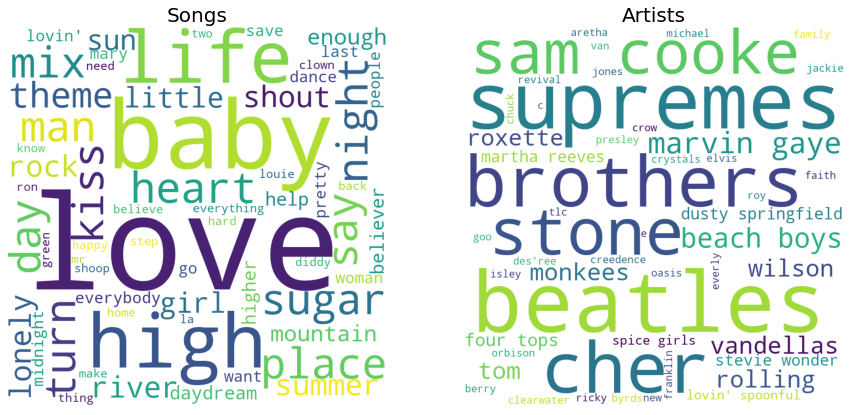

In [42]:
# Plot wordcloud of song titles and artists
fig = plt.figure(figsize = (15, 15))
for i, show_ in enumerate(['song', 'artist']):
    ax = fig.add_subplot(1, 2, i+1)
    wordcloud = wordcloud_clstr(df_all, 'Easy Pop/Rock', show=show_)
    title_plot = ['Songs', 'Artists']
    ax.imshow(wordcloud)
    ax.set_title(title_plot[i], fontsize=20)
    ax.axis('off')

<center style="font-size:14px;font-style:default;"><b>Figure 5.37 Word Cloud for Song Titles (left) and Artist (right) of the Easy Pop/Rock Cluster</b></center>

<div style="text-align: justify"><b>First is the Easy Pop/Rock Cluster.</b> The figure above shows a word cloud of the song titles and the artists or singers whose songs are included in this cluster. The size of the words shown correspond to the frequency of its appearance in the cluster. From these figures we can take a look at the dominance or diversity of themes and singers in the cluster, as well as comparison with the other clusters.</div> <br>

<div style="text-align: justify">Songs in this cluster are described as <b>happy, upbeat, and easy-listening songs</b>. Their defining features are its high energy, valence, and tempo with low danceability and acousticness. The dominant theme here is love with words such as <i>'love', 'baby', 'kiss', and 'sugar'</i> having high frequency. Dominant artists in this cluster are mixed soloists and bands like <b>The Beatles, Cher, Sam Cooke, and The Supremes</b>.</div>

## Senti

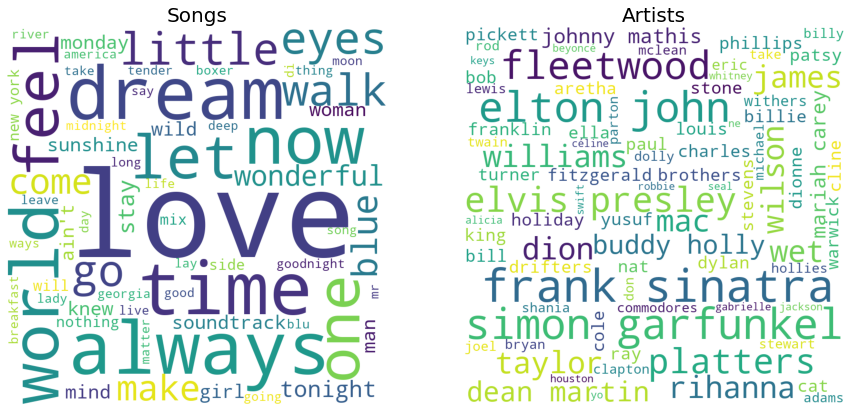

In [43]:
# Plot wordcloud of song titles and artists
fig = plt.figure(figsize = (15, 15))
for i, show_ in enumerate(['song', 'artist']):
    ax = fig.add_subplot(1, 2, i+1)
    wordcloud = wordcloud_clstr(df_all, 'Senti', show=show_)
    title_plot = ['Songs', 'Artists']
    ax.imshow(wordcloud)
    ax.set_title(title_plot[i], fontsize=20)
    ax.axis('off')

<center style="font-size:14px;font-style:default;"><b>Figure 5.38 Word Cloud for Song Titles (left) and Artist (right) of the Senti Cluster</b></center>

<div style="text-align: justify"><b>Next is the Senti Cluster.</b> Songs in this cluster are described as <b>sentimental and mellow songs</b>. Their defining features are  high acousticness with low loudness, danceability, energy, and valence.</div> <br>

<div style="text-align: justify">In the song title word cloud, we can see the presence of words commonly associated with personal reflection such as <i>'time', 'always', 'dream', 'feel', 'world'</i> as well as the theme common across all clusters - 'love'. Artists in this cluster are dominated more by soloists than bands or groups. Some of the relatively more dominant artists are <b>Frank Sinatra, Simon Garfunkel, Elvis Presley, and Rihanna</b>. Dominant bands include <b>The Platters and Fleetwood Mac</b>.</div>

## Move

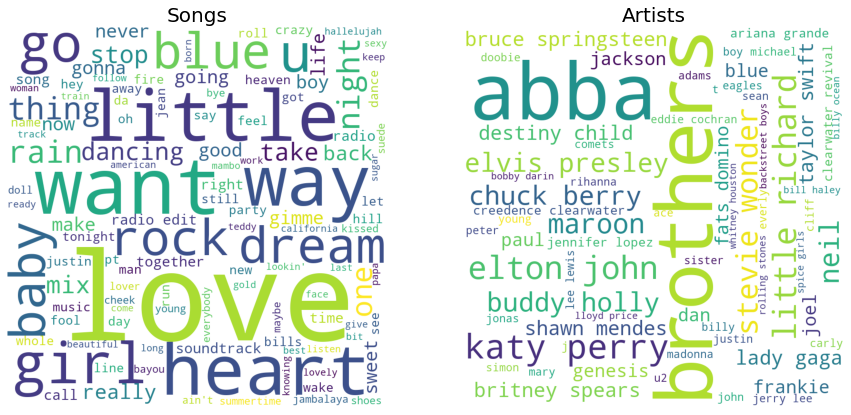

In [44]:
# Plot wordcloud of song titles and artists
fig = plt.figure(figsize = (15, 15))
for i, show_ in enumerate(['song', 'artist']):
    ax = fig.add_subplot(1, 2, i+1)
    wordcloud = wordcloud_clstr(df_all, 'Move', show=show_)
    title_plot = ['Songs', 'Artists']
    ax.imshow(wordcloud)
    ax.set_title(title_plot[i], fontsize=20)
    ax.axis('off')

<center style="font-size:14px;font-style:default;"><b>Figure 5.39 Word Cloud for Song Titles (left) and Artist (right) of the Move Cluster</b></center>

<div style="text-align: justify"><b>The Move Cluster.</b> Songs in this cluster are described as <b>happy and energetic songs mainly for dancing</b>. In fact, the word <i>'dancing'</i> is of the dominant words in the word cloud for the song title below. Their defining features are high loudness, danceability, energy, and valence with low acousticness.</div><br>

<div style="text-align: justify">The song title word cloud displays the presence of words depicting the 'love' theme such as <i>'love', 'heart', 'girl', 'baby', and 'want'</i>. Artists in this cluster have a more balanced mix of soloists and groups. Dominant artists are <b>Katy Perry, Maroon 5, Elton John, Stevie Wonder, ABBA, and Brothers</b>.</div>

## Chill

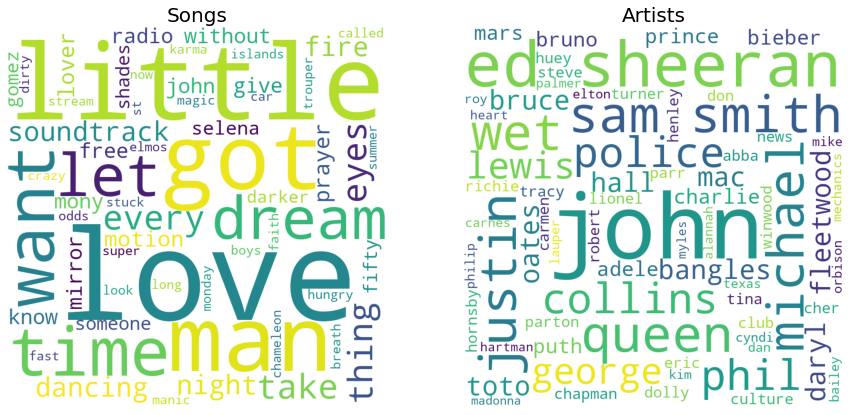

In [45]:
# Plot wordcloud of song titles and artists
fig = plt.figure(figsize = (15, 15))
for i, show_ in enumerate(['song', 'artist']):
    ax = fig.add_subplot(1, 2, i+1)
    wordcloud = wordcloud_clstr(df_all, 'Chill', show=show_)
    title_plot = ['Songs', 'Artists']
    ax.imshow(wordcloud)
    ax.set_title(title_plot[i], fontsize=20)
    ax.axis('off')

<center style="font-size:14px;font-style:default;"><b>Figure 5.40 Word Cloud for Song Titles (left) and Artist (right) of the Chill Cluster</b></center>

<div style="text-align: justify"><b>Now, we have Chill cluster.</b> Songs in this cluster are described as <b>sentimental and mellow songs that are still for dancing</b>. Their defining features are high danceability and acousticness with low loudness, energy, valence, and tempo.</div> <br>

<div style="text-align: justify">Again, <i>'love'</i> is the most dominant word in these clusters' song titles, along with <i>'little', 'man', 'got', 'time' and 'dream'</i> which were also identified in the Senti cluster. This makes sense since the Chill and Senti cluster have similar properties except for danceability, which is high for the former. Artists in this cluster are dominated more by soloists than groups and are noticeably more male artists. Examples are <b>Ed Sheeran, Phil Collins, Sam Smith, Queen, and The Police</b>.</div>

## Alternative Pop

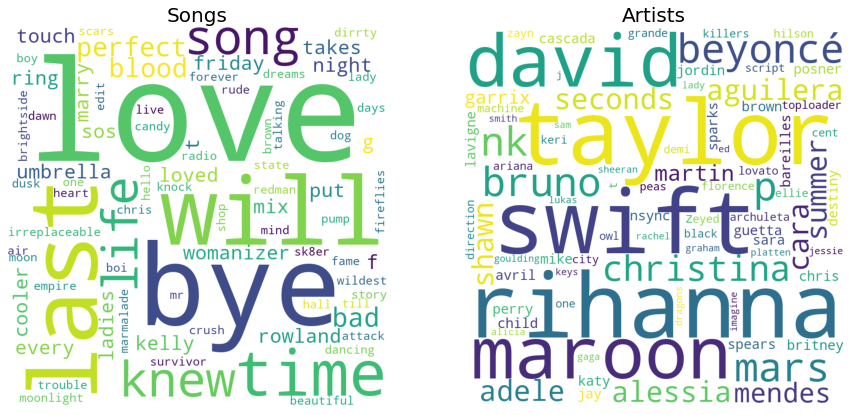

In [46]:
# Plot wordcloud of song titles and artists
fig = plt.figure(figsize = (15, 15))
for i, show_ in enumerate(['song', 'artist']):
    ax = fig.add_subplot(1, 2, i+1)
    wordcloud = wordcloud_clstr(df_all, 'Alternative/Pop', show=show_)
    title_plot = ['Songs', 'Artists']
    ax.imshow(wordcloud)
    ax.set_title(title_plot[i], fontsize=20)
    ax.axis('off')

<center style="font-size:14px;font-style:default;"><b>Figure 5.41 Word Cloud for Song Titles (left) and Artist (right) of the Alternative/Pop Cluster</b></center>

<div style="text-align: justify"><b>Last is the Alternative/Pop cluster.</b> Songs in this cluster are described as <b>sentimental yet upbeat and energetic songs</b>. Their defining features are high loudness, energy and tempo, with low danceability, acousticness, and valence.</div><br>

<div style="text-align: justify">The word <i>'love'</i> being the most dominant word in the song title word cloud depicts that again, the unifying theme for these songs are love, just like all of the previous clusters. Furthermore, words depicting themes of heartbreak or sorrow are dominant such as <i>'bye', 'last', 'loved', 'knew', 'blood' and 'time'</i>. Artists in this cluster are dominated more by soloists than groups. Dominant artists are <b>Rihanna, Taylor Swift, Christina Aguilera, Beyonce and Bruno Mars</b>. It should be noted that most of these artists are from the recent decades since this is an emerging cluster unseen in the earlier decades of music.</div>

### 5.5 Evolution Through the Decades

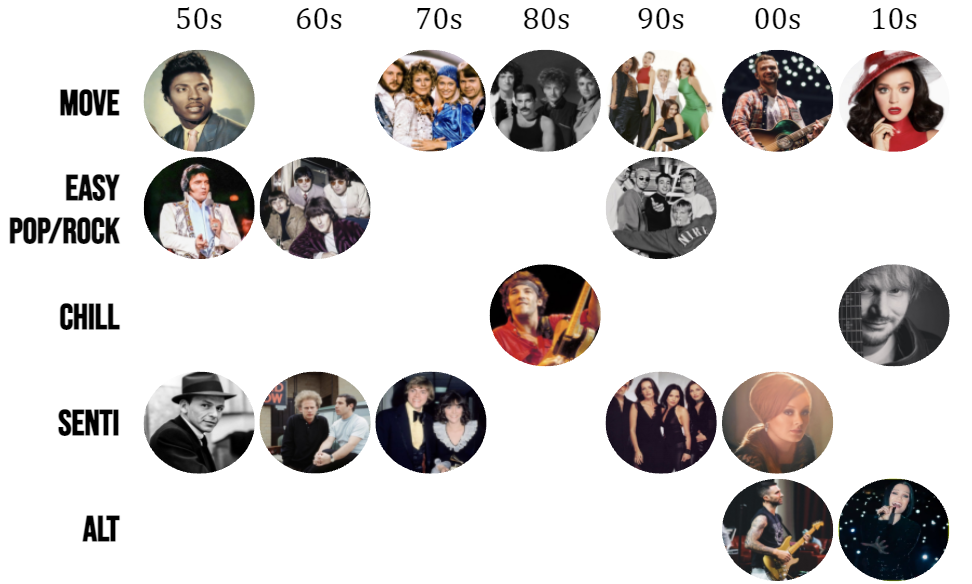

<center style="font-size:14px;font-style:default;"><b>Figure 5.42 Presence of the 5 Clusters Across the Decades</b></center><br>

<div style='text-align: justify;'> The figure above shows the presence of the identified clusters across the decades, appropriately visualized with photographs of one of the dominant artists of the specific cluster-decade combination. For example, Katy Perry is the artist highlighted from the Move cluster in the 2010's.</div><br>

<div style='text-align: justify;'>We see that the <b>Move</b> cluster is present in most decades as we hear from ABBA, Spice Girls and Justin Timberlake. This cluster seems to be a unifying cluster across generations, as songs are historically made for celebration and consequently, dancing. Songs from this cluster include <i>'Wannabe', 'Dancing Queen', 'SexyBack', and 'I Kissed a Girl'</i>.</div><br>

<div style='text-align: justify;'>The <b>Easy Pop/Rock</b> cluster, which is dominated by artists like Elvis Presley, the Beatles, and the Backstreet Boys are present in the hit songs of the 50's, 60's and 90's. They created songs that are positive, energetic, and upbeat that may be more suitable for easy listening and lounging more than dancing. The low danceability may be a reason for its absence in the hit songs of other decades. Hit songs from this cluster include <i>'Here Comes The Sun', 'All You Need is Love', and 'As Long as You Love Me'</i>.</div><br>

<div style='text-align: justify;'>Songs from the <b>Senti</b> cluster also have a place in the hit songs of most decades, specifically 50's, 60's, 70's, 90's, and the 2000's. This is probably due to the fact that music is a universal language for expressing or connecting to our feelings, and it is normal that everyone might experience periods of negative or unhappy emotions. Some of the artists shown here are Frank Sinatra, The Corrs and Adele. Hit songs from this cluster include <i>'Come Fly With Me', 'What Can I Do', and 'Chasing Pavements'</i>. However, we notice that this cluster did not make it to the hit songs of the most recent decade, where other clusters that are emerging or are being revived takes the spotlight.</div><br>

<div style='text-align: justify;'>The first of these clusters is the <b>Chill</b> cluster. It gained popularity in the 80's with songs by Bruce Springsteen that are sentimental and mellow, yet appropriate for dancing. An example of Bruce's song in this cluster is <i>'I'm On Fire'</i>. In the recent decade of 2010's, this cluster had a place in the hit songs again with artists like Ed Sheeran bringing back the vibe with songs such as <i>'Photograph', 'Thinking Out Loud' and 'Perfect'</i>. These songs gained popularity as songs that are meant for slow dancing. </div><br>

<div style='text-align: justify;'>The last cluster is the <b>Alternative/Pop</b>, which is only present in the more recent decades. As described, these songs depict more negative emotions but are also upbeat and energetic. Artists like Maroon 5 and Jessie J offer songs like <i>'Animals' and 'Flashlight'</i>.</div>

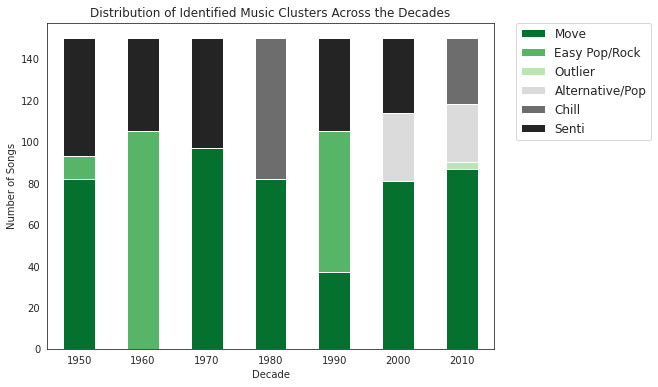

In [47]:
# Plot distribution of clusters per decade
spotify_color_stacked = (sns.color_palette('Greens')[1::2][::-1] +
                         sns.color_palette('binary')[:4:3] +
                         sns.color_palette('binary')[-1::])

# Set theme
sns.set_style("white")
sns.set_palette(spotify_color_stacked)

# Group by decade
summary = (df_all.groupby(['decade', 'cluster_label'])
           ['song'].count().unstack().fillna(0))
custom_dict = {50: 0, 60: 1, 70: 2, 80: 3, 90: 4, 0: 5, 10: 6}
summary['rank'] = summary.index.map(custom_dict)
summary.sort_values(by=['rank'],inplace=True)

# now drop the 'rank' column
summary.drop(labels=['rank'],axis=1, inplace=True)
summary = summary[['Move', 'Easy Pop/Rock', 'Outlier',
                   'Alternative/Pop', 'Chill', 'Senti']]
summary.plot(kind='bar', stacked=True, figsize=(8,6))
plt.xticks(ticks=range(7), labels=[1950, 1960, 1970, 1980, 1990, 2000, 2010])
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.xticks(rotation=0)
plt.title('Distribution of Identified Music Clusters Across the Decades')

plt.show()

display(HTML('<center style="font-size:14px;font-style:default;">'
         '<b>Figure 5.43 Cluster Distribution Across the'
             ' Decades</b></center>'))

<div style='text-align: justify;'>  Shown in the figure above is the distribution of the clusters per decade. It could be observed that most decades have a balanced presence of the clusters in them which indicates the diversity of music tastes across generations.If we look at the clusters that have high valence or positivity as one of their defining features <b>(Move and Easy Pop/Rock)</b>, we notice that these clusters always take up the major portion of the hit song distribution. This implies that most people still prefer more positive songs across the decades.Lastly, we observe the steady emergence of the <b>Alternative cluster</b> which are sentimental but upbeat songs. These songs that upbeat may signal a hopeful, empowering take of rising above negativity. For example, a hit song in this cluster is <i>'Fight Song'</i> by Rachel Platten is about the struggle with anxiety and overcoming it.</div>

## 6. Conclusion and Recommendation


<div style='text-align: justify;'> Across the years, <b>five different musical themes emerged</b> and these groups were given names and interpretations. First, there is a cluster called <i>“Easy Pop/Rock”</i> which is described as songs that can boost your mood. These songs are happy and upbeat because of high energy and tempo while having low danceability. Next cluster is <i>“Senti”</i> which is short for sentimental. These mellow songs have low energy and high acousticness; these songs are generally unhappy and relatable. Then, there is a cluster called <i>“Move”</i>. True to its name, these tunes are great for dancing or parties because of high danceability, energy, and tempo. Fourth, the group discovered a <i>“Chill”</i> cluster which listeners can play when they want to hear relaxing beats. These songs are characterized by low energy and loudness but with high danceability. These are perfect for chill and slow dancing. Lastly, at the turn of the century, a new cluster called <i>“Alt”</i> or alternative music was born. This music is different from the other clusters because the music is emotional but upbeat.</div><br>

<div style='text-align: justify;'> Among these clusters, <i>“Move”</i> and <i>“Senti”</i> are present most of the decades. Meanwhile, <i>“Easy Pop/Rock”</i> songs are popular before 2000’s while <i>“Alt”</i> emerged at the start of 2000’s. Interestingly, the <i>“Chill”</i> cluster was present when the <i>“Senti”</i> cluster was out in the 1980’s and 2010’s. Looking at the distribution of the clusters, the group noticed that happier songs take a major portion of each decade which implies that most people connect to happier songs to try to boost their mood. Also, the appearance of <i>“Alt”</i> at the start of 2000’s signaled a hopeful and empowering take on rising above negativity.</div><br>

<div style='text-align: justify;'>The insights discovered for this project are helpful for three sectors. These are artists, users, and Spotify itself. For <b>artists</b>, they can produce music that ride the current popularity of emotional and upbeat songs (“Alt”). They can also generate danceable and upbeat songs that are greatly received across the decades. They can also re-create popular past themes and experiment on adding their own flavor to it. Another use case is that <b>users</b> can discover songs from other decades that are similar to their current favorites. Users can explore different artists and songs within the same cluster and decade. Finally, <b>Spotify</b> can harness this study to diversify and improve their curated songs and playlists. </div><br>

<div style='text-align: justify;'> In further studies of Spotify song data researchers can explore more playlists, songs, and more features so as to derive more useful insights. They can take it one step further by analyzing actual song lyrics instead of just song titles to get a deeper look into themes through clustering.They can also try utilizing more clustering techniques, validation methods, and soft clusters that will give more in-depth analysis to song themes across decades. Possible next steps include reverse engineering on Spotify song audio features and performing machine learning algorithms to predict features such as artist and song popularity as well as streams.</div><br>
    
<div style='text-align: justify;'>Finally, we impart the idea that <i>"Good music is meant to be enjoyed by all."</i> Through our analysis, everyone can diversify their choices and widen their perspective on music. </div>

## 7. References

- Wikipedia Contributors. (2019, June 13). Spotify. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Spotify
- Web API Reference | Spotify for Developers. (2019). Spotify.com. https://developer.spotify.com/documentation/web-api/reference/
- RPubs - Unsupervised Learning Using K-Means: Spotify Audio Feature Analysis. (n.d.). Rpubs.com. Retrieved September 16, 2021, from https://rpubs.com/alfandash/lbb-unsupervised-learning
- Classifying genres in R using Spotify data. (2019, December 20). Kaylin Pavlik. https://www.kaylinpavlik.com/classifying-songs-genres/
- Rau, T. E. (2021, April 9). Clustering & Forecasting | Spotify Songs Audio Features. Medium. https://tomasezequielrau.medium.com/clustering-forecasting-spotify-songs-audio-features-5b2c21f0a6b9
- News, A. B. C. (n.d.). Rachel Platten Explains the Real Story Behind Her Hit “Fight Song.” ABC News. https://abcnews.go.com/Entertainment/rachel-platten-explains-real-story-hit-fight-song/story?id=35628664
- Nijkamp, R. (2018). Prediction of product success: explaining song popularity by audio features from Spotify data [Review of Prediction of product success: explaining song popularity by audio features from Spotify data]. , the Faculty of Behavioural, Management and Social Sciences. https://essay.utwente.nl/75422/1/NIJKAMP_BA_IBA.pdf

## 8. Acknowledgements

<div style='text-align: justify;'> First and foremost, we would like to thank <b>each of our families</b> for the unwavering support and unconditional understanding during the span of the whole term. We wouldn't have completed it without their support. </div><br>

<div style='text-align: justify;'>Second, we would like to thank <b>Prof Christian Alis</b> for all of the knowledge you imparted to us. We appreciate the training no matter how difficult it had been. Comparing now and before the term started, we realized how much we have grown as future data scientists due to your mentorship. </div><br>

<div style='text-align: justify;'>We also want to thank all of our <b>mentors and professors</b> from the other subjects. Thanks for taking the time to hear out and answer our inquiries no matter how simple they may be. Special mention, <b>Prof Alva.</b></div><br>

<div style='text-align: justify;'>Lastly, <b>MSDS 2022</b>, we did it. Another term done. Thanks for all the support, lets finish even stronger.</div>